# 11.1 PDE Solvers: Finite Difference Methods 2 

Lecture 11.1
Matt Piggott

## Table of Contents

```{contents}
```

## Learning objectives: 


* To review what we've seen several times already on finite difference approximations to derivatives, how to derive them and how to estimate errors. 
    

    
* To review the numerical solution of advection-diffusion problems (steady and unsteady) using upwind and central difference methods and the very distinct accuracy/stability properties of each.



* Understand and recognise some of the issues that result from rapid (relative to the mesh resolution) variations in the solution - e.g. the presence of sharp boundary layers, and how this related to *stability*. To understand how a move away from uniform mesh resolution is one way to alleviate these issues.

    

* To understand ***three key stability issues*** - where these come from and how they can be "managed".  One of these is the *cell Peclet number* related issue from the previous lecture, while the other two relate to the time derivative and limiting the *speed of information propagation* on the discrete mesh.



* To consider how eigenvalue analysis of the discretisation matrix can be combined with theory we saw for ODE solvers to consider stability issues for PDEs.

## Finite differences - review


### The forward difference

We can turn the formal definition of a derivative

$$f'(x_0)=\lim_{h\rightarrow 0} \frac{f(x_0+h)-f(x_0)}{h} $$

into an approximation rule by replacing the limit as $h$ approaches zero (i.e. the $\text{lim}_{h\rightarrow\infty}$) with a small but finite $\Delta x$ value:

$$ f'(x_0)\approx \frac{f(x_0+\Delta x)-f(x_0)}{\Delta x},\;\;\;\; \Delta x>0. $$

Since this approximate gradient method uses values of $x$ greater than $x_0$ ($\Delta x>0$) to estimate the derivative at $x_0$, this approach is known as a **forward difference**. 

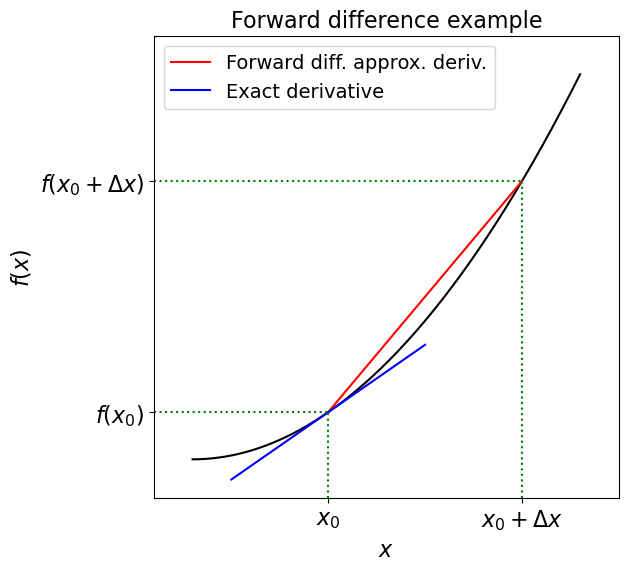

In [1]:
from matplotlib import pyplot as plt
import numpy as np
fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(111)
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_title('Forward difference example', fontsize=16)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$f(x)$', fontsize=16)
# define our x for plotting purposes
x = np.linspace(0, 1, 1000)

# define our example function and its exact derivative

def f(x):
    return x**2

def df(x):
    return 2 * x

# plot the 'exact' solution
ax1.plot(x, f(x), 'k')
# choose and plot two x locations to take the difference between
x0 = 0.35
dx = 0.5
x1 = x0 + dx
# plot a line representing the discrete derivative
ax1.plot([x0, x1], [f(x0), f(x1)], 'r', label = 'Forward diff. approx. deriv.')

# plot a line representing the exact derivative (given by function f(.)) at x=x0 in blue
# choose an h purely for plotting purposes, we use the true derivative df to find the slope
h = dx / 2
ax1.plot([x0 - h, x0 + h], [f(x0) - h * df(x0), f(x0) + h * df(x0)], 'b', label = 'Exact derivative')

# add some axes labels and lines etc
ax1.set_xticks((x0, x1))
ax1.set_xticklabels(('$x_0$', '$x_0+\Delta x$'), fontsize=16)
ax1.plot([x0, x0], [-0.1, f(x0)], 'g:')
ax1.plot([x1, x1], [-0.1, f(x1)], 'g:')
ax1.set_yticks((f(x0), f(x1)))
ax1.set_yticklabels(('$f(x_0)$', '$f(x_0+\Delta x)$'), fontsize=16)
ax1.plot([-0.1, x0], [f(x0), f(x0)], 'g:')
ax1.plot([-0.1, x1], [f(x1), f(x1)], 'g:')
ax1.legend(loc='best', fontsize=14);

### The backward difference

The **backward difference** is an equally valid approximation

$$ f'(x_0)\approx \frac{f(x_0)-f(x_0-\Delta x)}{\Delta x},\qquad \Delta x>0 $$


### The central difference

Also the **central difference**

$$ f'(x_0) \approx \frac{f(x_0+\Delta x)-f(x_0-\Delta x)}{2\Delta x},\qquad \Delta x>0$$

### Taylor series to estimate accuracy

Recall that it is fairly straightforward to use [Taylor series expansion](http://mathworld.wolfram.com/TaylorSeries.html) to estimate the accuracy of the method. 

The Taylor series in one dimension tells us that we can approximate the value of the function at a location in terms of its value, and value of its derivative, at a nearby point:

$$
f(x_0+\Delta x) = f(x_0) + \Delta xf'(x_0) + \frac{\Delta x^2}{2!}f''(x_0) + \frac{\Delta x^3}{3!}f'''(x_0) + \mathcal{O}(\Delta x^4)
$$

<br>
 
#### Forward difference

Rearranging we find that 
 
$$ f'(x_0) = \frac{f(x_0+\Delta x)-f(x_0)}{h} + \mathcal{O}(\Delta x) $$

i.e. the error in the forward Euler approximation of the first derivative is 

$$ \left|f'(x_0) - \frac{f(x_0+\Delta x)-f(x_0)}{\Delta x}\right| = \mathcal{O}(\Delta x) $$

and we can include the particular for of the leading order error term:

$$ f'(x_0) - \frac{f(x_0+\Delta x)-f(x_0)}{\Delta x} = - \frac{\Delta x}{2} f''(x_0) + \mathcal{O}(\Delta x^2) $$


The forward difference therefore represents a first-order accurate approximation to the first derivative.


<br>

#### Backward difference

Similarly


$$ f'(x_0)  - \frac{f(x_0)-f(x_0-\Delta x)}{\Delta x} = \frac{\Delta x}{2} f''(x_0) + \mathcal{O}(\Delta x^2) $$

The backard difference therefore also represents a first-order accurate approximation to the first derivative.


<br>

#### Central difference

In contrast the central difference represents a second-order approximation:

$$ \left|f'(x_0) - \frac{f(x_0+\Delta x)-f(x_0-\Delta x)}{2\Delta x}\right|  =  \mathcal{O}(\Delta x^2)$$


### Finite difference approximation of second (and higher order) derivatives

A finite difference approximation of a second derivative can be found by using information from three locations:

$$
f''(x_0)\approx\frac{f(x_0+\Delta x)-2f(x_0)+f(x_0-\Delta x)}{\Delta x^2}
$$

This is a second-order approximation in the sense that 

$$
\left|f''(x_0) - \frac{f(x_0+\Delta x)-2f(x_0)+f(x_0-\Delta x)}{\Delta x^2}\right|  =  \mathcal{O}(\Delta x^2)
$$

## The method of undetermined coefficients [$\star$]
```{admonition} Optional Content
:class: dropdown
A way to formalise the derivation of numerical approximations is the *method of undetermined coefficients*.

We approximate the derivative in question using values of the function at neighbouring locations. 

For example

$$ f^{(n)}(x_i) \approx g(\ldots,\; f_{i-2}, \; f_{i-1}, \; f_{i}, \; f_{i+1}, \; f_{i+2}, \; \ldots), $$

where the $g$ function indicates we are going to combine these values in some way, and we use the shorthand notation $f_i=f(x_i)$, etc. 

The RHS of this expression will be our finite difference approximation.

The number of nearby function values used to calculate the derivative is called the *stencil width* or *stencil size*. 

In general the larger the stencil, the better the approximation to the derivative.

The overall idea of this approach is to determine the most accurate discretisation of the derivative at $x_i$ based on use of an $N$-point stencil.
```

```{admonition} Optional Content
:class: dropdown
Using this notation we can rewrite the approximation above as

$$
f''(x_0)\approx\frac{f(x_0+\Delta x)-2f(x_0)+f(x_0-\Delta x)}{\Delta x^2}\\
=\frac{f_{i+1} - 2f_i + f_{i-1}}{\Delta x^2}.
$$
```

```{admonition} Optional Content
:class: dropdown
For example, in the case of a second-order derivative and a three-point (symmetric or centred) stencil (and the fact that in the finite difference method we generally assume that $g$ is a linear function) we have:

$$
f''(x_i) 
& \approx g(\; f_{i-1}, \; f_{i}, \; f_{i+1}\; )\\[5pt]
& = a_{-1}\;f_{i-1}+ a_0\; f_{i} + a_{1}\; f_{i+1},
$$

and our job is to determine the constant coefficients $\{a_{-1},\;a_0,\;a_{1}\}$.

We can draw a schematic of this stencil like this

Note that some people call the computational stencil a computational *molecule*

```

```{figure} Images/Lecture11.1/centered_stencil.svg
:width:75%
```


```{admonition} Optional Content
:class: dropdown
Using the notation $f_i = f(x_i)$, $\;f'_{i+1}=f'(x_{i+1})$ etc, Taylor series tells us that

$$
f_{i-1} &= f_i - h f'_i + \frac{h^2}{2} f''_{i} - \frac{h^3}{6!} f'''_{i} + \mathcal{O}(h^4),\\[5pt]
f_{i+1} &= f_i + h f'_i + \frac{h^2}{2} f''_{i} + \frac{h^3}{6!} f'''_{i} + \mathcal{O}(h^4),
$$

substituting in to $\;f''_i = a_{-1}\;f_{i-1}+ a_i\; f_{i} + a_{i+1}\; f_{i+1}\;$ and collecting terms yields

$$
f''_i & = (a_{-1} + a_i + a_{i+1})\,f_i + (a_1 - a_{-1})\,h\,f'_i \\[5pt]
       & \;\;\;\;\;\;\; + (a_1 + a_{-1})\,\frac{h^2}{2}\,f''_i + (a_{-1} - a_{1})\,\frac{h^3}{6}\,f'''_i + \mathcal{O}(h^4).
$$

<br>

The only way we can ensure that the RHS does indeed provide an approximation to the second-order derivative that appears on the LHS is to require that the multipliers in front of the non-second-order derivative term are zero (so they drop out), and the multiplier in front of the second-order terms is one:

$$ (a_{-1} + a_i + a_{i+1})=0, \;\;\;\;\;\;
(a_1 - a_{-1})\,h = 0, \;\;\;\;\;\;
(a_1 + a_{-1})\,\frac{h^2}{2} = 1. $$

We could write this as a $3\times 3$ linear system and invert, or here it's fairly trivial to spot that the solution to this problem is given by

$$a_{-1}=\frac{1}{h^2},\;\;\;\;\;\; a_0 = -\frac{2}{h^2},\;\;\;\;\;\; a_1 = \frac{1}{h^2},$$

and therefore 

$$ f''_i = a_{-1}\;f_{i-1}+ a_i\; f_{i} + a_{i+1}\; f_{i+1} + \mathcal{O}(h^2) = \frac{f_{i+1} - 2f_i + f_{i-1}}{h^2} + \mathcal{O}(h^2).$$

We have thus derived the same second order accurate central difference scheme as before:

$$ f''_i \approx \frac{f_{i+1} - 2f_i + f_{i-1}}{h^2}. $$

Note that with this approach of undetermined coefficients we can in principle compute any derivative on any stencil, e.g. a stencil which is not symmetric - such as a one-sided stencil at a boundary. For more on this see the *homework exercises*.

If we had started from a five point stencil for example, we would have had enough free parameters to cancel enough terms in the Taylor series analysis to result in a fourth-order accurate scheme.
```

## Advection-diffusion: a very important model problem

Recall the important PDE model problem of time-dependent advection-diffusion in one-dimension (1D):

$$\frac{\partial c}{\partial t} + U\frac{\partial c}{\partial x} = \kappa\frac{\partial^2 c}{\partial x^2},$$

where $\,t\,$ is time, $\,x\,$ is our single space dimension. You can think of $\,c\,$ as being a concentration of some quantity which is being *advected* with prescribed velocity $\,U\,$, and *diffused* with the diffusivity $\,\kappa$.

[$U\,$ here is a scalar as we're in one spatial dimension but ultimately we'll be interested in the multi-dimensional case of course.]

<br>

with *initial condition* (this is a scalar first-order (in time) problem, as so we only need one):

$$c(x,0)=c^0(x).$$

<br>

and *boundary conditions* (this is second-order in space and so we need two conditions, and here they are of "Dirichlet" type):

$$c(0,t) = 0, \;\;\;\; c(L,t)=c_E. $$


### Problem non-dimensionalisation

This problem can be written in dimensionless form as

$$\frac{\partial \hat{c}}{\partial \hat{t}} + \frac{\partial \hat{c}}{\partial \hat{x}} = \frac{1}{Pe}\frac{\partial^2 \hat{c}}{\partial \hat{x}^2},$$

with initial/boundary conditions

$$\hat{c}(\hat{x},0) = \hat{c}^0(x), \;\;\;\; \hat{c}(0,\hat{t}) = 0, \;\;\;\; \hat{c}(1,\hat{t})=1. $$

$Pe$ is termed the Peclet number and is defined by 

$$Pe = \frac{UL}{\kappa},$$

where $L$ is the length scale used to non-dimensionalise the problem.

Note that $\,Pe\,$ is now the only parameter in our problem, which emphasises its importance both to the physics of the continuous problem as well as the discrete numerical system as we shall show.


When considering the problem in this non-dimensional form it is common to drop the hats.

### The steady-state advection-diffusion problem (a BVP)

If we assume that our problem is indepdent of time (it is steady) then this means that advection and diffusion are balancing one another, and we are then left with the problem for $c\equiv c(x)$ (we drop the $t$ dependence here as we've stated the solution doesn't change with time):

$$\frac{\partial {c}}{\partial {x}} = \frac{1}{Pe}\frac{\partial^2 {c}}{\partial {x}^2},$$

<br>

The solution to this particular problem can be shown to be given by 

$$ c(x) = \frac{\exp\left(Pe \; x\right) - 1}{\exp(Pe) - 1}.$$

(In the dimensional case it would be $ c(x) = c_E\frac{\exp\left(Pe \frac{x}{L}\right) - 1}{\exp(Pe) - 1}$).

<br>

Recall how for different values of the Peclet number the solution to this problem becomes more and more smooth (small $Pe$) or less smooth - forming a boundary layer when $Pe$ is large:

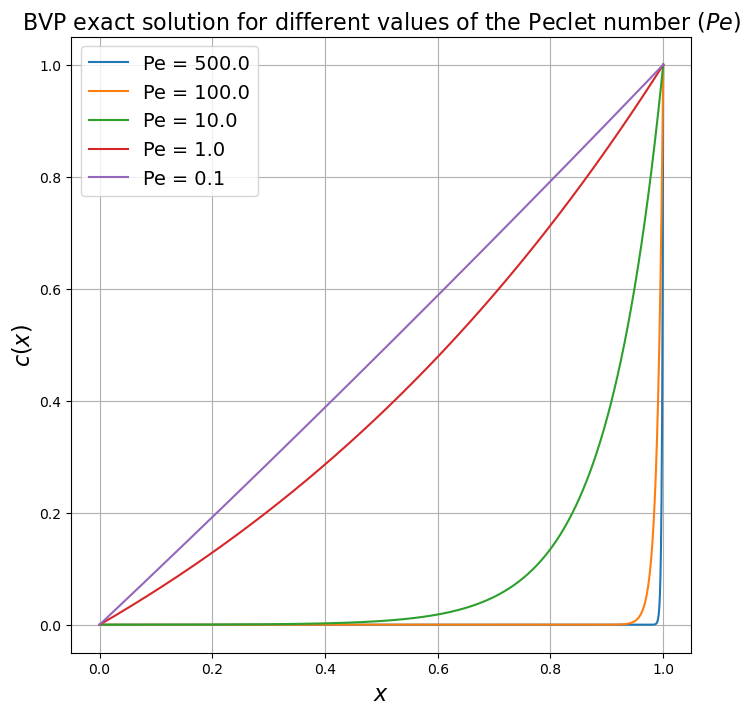

In [2]:
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$c(x)$', fontsize=16)
ax1.set_title('BVP exact solution for different values of the Peclet number ($Pe$)', fontsize=16)
x = np.linspace(0, 1, 1000)
for i, Pe in enumerate([500, 100, 10, 1, 0.1]):
    c = (np.exp(Pe * x) - 1) / (np.exp(Pe) - 1)
    ax1.plot(x, c, label='Pe = {:.1f}'.format(Pe))

ax1.grid(True)
ax1.legend(loc='best', fontsize=14);

#### Defining a grid (or mesh)

To solve this one dimensional BVP (using a linear algebra approach) we need to convert the continuous PDE into a discrete system to solve on a finite computer.

To do this we first define a discrete (i.e. a finite number of) mesh or grid of points at whose locations we will seek the solution.

To keep things simple for now we will assume these points are equally spaced, and we assume we use $N$ points to discretise our domain (recall in dimensional units this is $x\in[0,L]$).

To deal with the imposition of boundary conditions we will use an approach here where our $N$ *internal* mesh nodes are located within the domain, and we introduce two extra *ghost* nodes just outside the domain as in the figure below.

```{figure} Images/Lecture11.1/1d_grid.svg
:width: 100%
```    

As we shall see shortly these ghost nodes will be used to help impose our boundary conditions. 

<br>

We have ***made a choice*** here over the method we use to deal with our BCs - there are many other options! In particular, approaches where the first and last node coincide exactly with the boundary locations.

<br>

Since we will assume that we don't yet know anything about the expected solution behaviour it makes sense for our mesh of points to be equally spaced, or *equidistant*, i.e. we have a constant mesh spacing $\Delta x$.

Another way of saying this is that our mesh is *uniform*.

Our *interior* mesh points or solution nodes are therefore located at

$$x_i=\left(i-\frac{1}{2}\right)\Delta x, \;\;\;\;\textrm{for}\;\;\;\;  i=1,\ldots,N, \;\;\;\;\textrm{where}\;\;\;\; \Delta x = \frac{L}{N}.$$ 

#### Discretising using a three-point stencil and central differences for advection and diffusion

Let's conside the stencil

```{figure} Images/Lecture11.1/Adv-diff_1D_centred_stencil.svg
:width: 75%
```    
the blue point indicates that we are going to form a discretisation at node $i$.


The most obvious choice for diffusion is just to use the second-order central scheme we discussed and implemented above:

$$ \left.\kappa\frac{\partial^2 c}{\partial x^2}\right|_{x_i} \approx \kappa\frac{c_{i+1} - 2c_i + c_{i-1}}{\Delta x^2}.$$

The fact that this is second-order accurate motivates us to attempt to use the same order of accuracy discretisation for the advection term. 

The advection term involves a first derivative, and we know from earlier that a central difference of a first derivative is second-order accurate (whereas forward and backward are only first-order accurate).

So a sensible discretisation choice would seem to be

$$ \left.U\frac{\partial c}{\partial x}\right|_{x_i} \approx U\frac{c_{i+1} - c_{i-1}}{2\Delta x}.$$


We can combine these two discrete terms and update the set of algebraic equations we derived above for the diffusion only problem (note that the discretisation of the boundary conditions does not need to change here now that we have included advection - this won't always be the case):


$$
  \begin{cases}
\frac{1}{2}(c_0 + c_1) &= 0 \\[5pt]
\kappa\frac{c_{i+1} - 2c_i + c_{i-1}}{h^2} - U\frac{c_{i+1} - c_{i-1}}{2\Delta x} &= 0 \\[5pt]
\frac{1}{2}(c_N + c_{N+1}) &= c_E
  \end{cases}
$$
for $i=1,2,\ldots,N$.

(To keep things looking like the earlier diffusion problem we have considered the BVP in the form $\kappa\frac{\partial^2 c}{\partial x^2}-U\frac{\partial c}{\partial x}=0$, we could multiply through by a minus sign here, and in the corresponding set of algebraic equations, and it would change nothing about our discretisation and the corresponding numerical solution.)


This can be written in matrix form as


$$\begin{pmatrix}
    \frac{1}{2} & \frac{1}{2} & 0 & \ldots & \dots  & 0 \\
    \left\{\frac{\kappa}{\Delta x^2} + \frac{U}{2\Delta x}\right\} & \left\{-\frac{2\kappa}{\Delta x^2}\right\} & \left\{\frac{\kappa}{\Delta x^2} - \frac{U}{2\Delta x}\right\} & 0 & & \vdots \\
    0 &  &  & \ddots &  & \vdots \\
    \vdots &  &  &  &  & 0 \\
      &    & 0 &\left\{\frac{\kappa}{\Delta x^2} + \frac{U}{2\Delta x}\right\} & \left\{-\frac{2\kappa}{\Delta x^2}\right\} & \left\{\frac{\kappa}{\Delta x^2} - \frac{U}{2\Delta x}\right\}\\    
    0 & \ldots & \ldots & 0 & \frac{1}{2}  & \frac{1}{2}
\end{pmatrix}
\begin{pmatrix}
c_0\\
c_1\\
\vdots\\
\\
\vdots\\
c_N\\
c_{N+1}
\end{pmatrix} = 
\begin{pmatrix}
0\\
0\\
\vdots\\
\\
\vdots\\
0\\
c_E
\end{pmatrix}
$$

which again can be considered in the form $\, A\boldsymbol{c}=\boldsymbol{b}\, $ with solution 
$\,\boldsymbol{c}=A^{-1}\boldsymbol{b} $.


Let's implement this method and see what difference the inclusion of advection makes to the (numerical) solution.


#### Dealing with Dirichlet boundary conditions

Recall that our BCs for this problem were specified in Dirichlet form:

$$c(0,t) = 0, \;\;\;\; c(L,t)=c_E. $$

Since we set up our mesh above such that $x=0$ was located exactly mid-way between the left most ghost node and the first interior node (and similarly at the right hand boundary) we can approximate the boundary conditions as

$$
x=0: & \;\;\;\; \frac{1}{2}(c_0 + c_1) = 0, \\[5pt]
x=L: & \;\;\;\; \frac{1}{2}(c_N + c_{N+1}) = c_E,
$$

where $c_i$ is the numerical solution at node $i$. The above expressions are just using linear interpolation of course between the two nodes straddling the boundary location.

Note that if we perform a Taylor series approximation we will be able to see that these approximations at the boundaries are second-order accurate. This is good as it will agree with the order of accuracy of the ODE discretisation we will see shortly. 

Note that generally, too high an accuracy in approximating the BCs could be a waste of effort, but too low might compromise the overall accuracy of the solver throughout the entire domain!

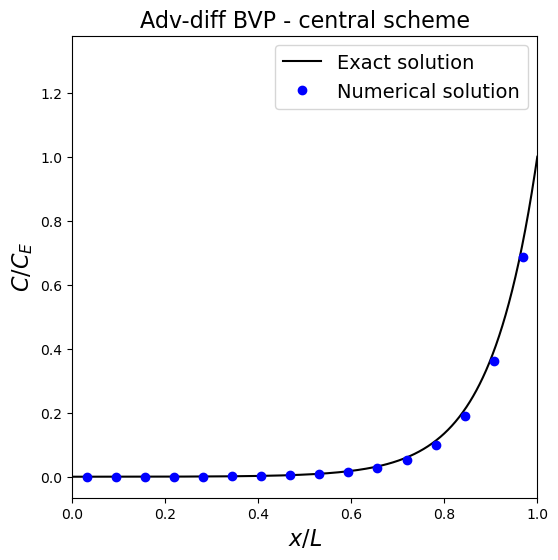

In [3]:
kappa = 0.005
L = 1
Pe = 10
U = Pe * kappa / L
CE = 1

def BVP_AD_central(L, U, kappa, CE, N):
    """ function to assemble and solve the AD BVP problem
    using central differences for both adv and diff.
    
    Returns the mesh x and the solution C
    """
    dx = L / N
    x = np.linspace(-dx / 2, dx / 2 + L, N + 2)
    A = np.zeros((N + 2, N + 2))
    b = np.zeros((N + 2))
    # interior points
    r_diff = kappa / dx**2
    r_adv = 0.5 * U / dx
    for i in range(1, N + 1):
        A[i, i - 1] = r_diff + r_adv
        A[i, i] = -2 * r_diff
        A[i, i + 1] = r_diff - r_adv
        b[i] = 0
    # BC1
    A[0, 0] = 0.5
    A[0, 1] = 0.5
    b[0] = 0
    # BC2
    A[N + 1, N] = 0.5
    A[N + 1, N + 1] = 0.5
    b[N + 1] = CE  # BC2
    # invert matrix
    C = np.linalg.solve(A, b)
    return x, C


# call function to generate numerical solution
x, C = BVP_AD_central(L, U, kappa, CE, 16)

# construct the exact solution
xf = np.linspace(0, L, 1000)
Cex = CE * (np.exp(Pe * xf / L) - 1) / (np.exp(Pe) - 1)

# set up figure
fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(111)
ax1.plot(xf, Cex, '-k', label='Exact solution')
ax1.plot(x, C, 'ob', label='Numerical solution')
ax1.set_xlabel('$x/L$', fontsize=16)
ax1.set_ylabel('$C/C_E$', fontsize=16)
ax1.set_title('Adv-diff BVP - central scheme', fontsize=16)
ax1.legend(loc='best', fontsize=14)

# to exclude ghost points just restrict the x limit of the plot
ax1.set_xlim(0, 1);

___Observations___


- In this plot we have restricted the $x$ limits to the physical domain and so not plotted the ghost node solutions.


- The result looks pretty good, but let's check for robustness (a.k.a. stability) and the impact that changing the problem or the mesh resolution has.


- For this problem in non-dimensional form changing $Pe$ and $\Delta x$ is actually equivalent - it's a more challenging problem if we either make $Pe$ larger (as the boundary layer will get thinner relative to the mesh spacing), or if we make $\Delta x$ larger.  Let's experiment with the latter by solving the same problem in a series of coarsening meshes.

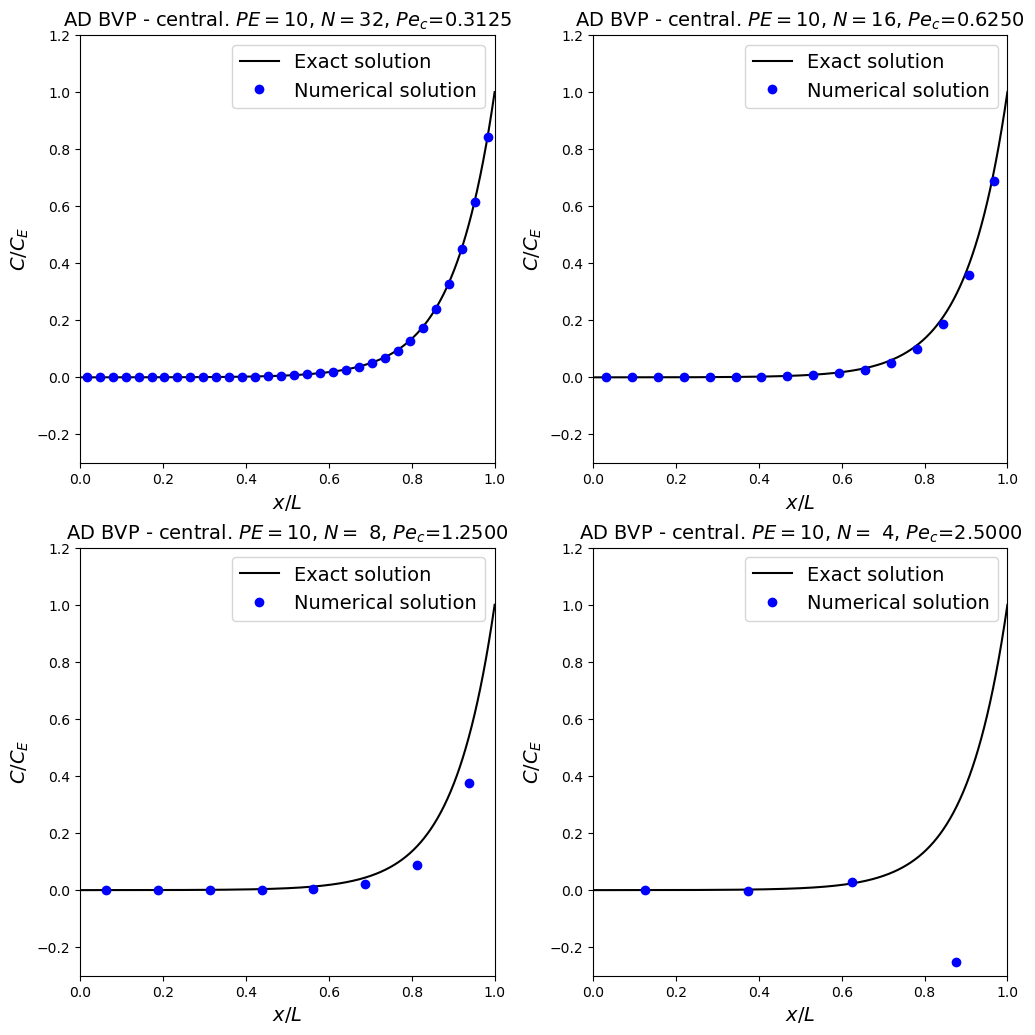

In [4]:
kappa = 0.005
L = 1
Pe = 10
U = Pe * kappa / L
CE = 1

# set up figure with 4 subplots to plot 4 resolutions
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# reshape so that we can iterate below over axs[i] instead of ax[i,j]
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=4)

# construct the exact solution on a fine mesh
xf = np.linspace(0, L, 1000)
Cex = CE * (np.exp(Pe * xf / L) - 1) / (np.exp(Pe) - 1)

# let's compute solution and plot for 4 different resolutions
for (i, N) in enumerate( (32 * .5**np.arange(0, 4)).astype(int) ):
    # call function to generate numerical solution
    x, C = BVP_AD_central(L, U, kappa, CE, N)
    axs[i].plot(xf, Cex, '-k', label='Exact solution')
    axs[i].plot(x, C, 'ob', label='Numerical solution')
    axs[i].set_xlabel('$x/L$', fontsize=14)
    axs[i].set_ylabel('$C/C_E$', fontsize=14)
    axs[i].set_title('AD BVP - central. $PE = 10$, $N=$%2i, $Pe_c$=%.4f' % (N,U*(L/N)/kappa), fontsize=14)
    axs[i].legend(loc='best', fontsize=14)
    # to exclude ghost points just restrict the x limit of the plot
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(-0.3, 1.2);

___More observations___


- For the first three resolutions we see the accuracy decreasing as we decrease the mesh resolution - this make sense based on our Taylor series error analysis earlier (indeed as we know the overall scheme should be second-order accurate we would expect an approximately four times increase in error every time we double the mesh spacing).


- But something qualitatively different has happened for the coarsest mesh resolution that we have considered - the numerical solution in the bottom-right frame now has spuriously jumped down (and note to a negative value) close to (or within) the boundary layer.


- This is a consequence of not having enough resolution to resolve the rapid change in the solution at this location.


- This behaviour can be referred to as instability, resulting in wiggles, oscillations, under/over-shoots, ...


- Note that we have also included a new quantity (the ***grid or cell Peclet number***) in the figure titles. It is defined as:

$$Pe_c :=  \frac{U\Delta x}{\kappa}.$$


- Theory states that the central scheme (for advection) is prone to instability (the presence of wiggles or over/under-shoots) when the grid Peclet number exceeds the value 2 - which is consistent with our plots above.


- NB. a grid Peclet number exceeding 2 does not mean we will definitely get wiggles, just that we may - we cannot rule them out.

#### Discrete fluxes [$\star$]
```{admonition} Optional Content
:class: dropdown
We can establish this limit of the cell Peclet number for the central scheme by considering *discrete fluxes*.

First note that for our above discretisation options we can write the discretised form of our continuous equation

$$U\frac{\partial c}{\partial x} = \kappa\frac{\partial^2 c}{\partial x^2}, \;\;\;\; c(0) = 0, \;\;\;\; c(L)=c_E, $$

as


$$ U\frac{c_{i+1} - c_{i-1}}{2\Delta x} 
= 
\kappa\frac{c_{i+1} - 2c_i + c_{i-1}}{\Delta x^2}.$$

Notice that this discrete equation is equivalent to the following *conservative form* for the discrete BVP:

$$\frac{\phi_i - \phi_{i-1}}{\Delta x} = 0, $$

where  

$$ \phi_i : = \frac{U}{2}\left( c_i + c_{i+1} \right)
-\kappa \frac{c_{i+1} - c_{i}}{\Delta x}. $$

This quantity can be called the total (i.e. sum of the advective and diffusive) scalar flux - note that due to its definition we can interpret it as being defined between node $i$ and $i+1$.
```

```{admonition} Optional Content
:class: dropdown
___Conservative form___ 

This is just a discrete version of the continuous BVP written in *conservative form*:

$$\frac{\partial}{\partial x}\phi = 0, \,\,\,\,\,\text{where}\,\,\,\,\, \phi = Uc - \kappa \frac{\partial c}{\partial x},$$

we'll come back to equations written in conservative form like this in lecture 9.
```

##### Stability

Consider a case where the advective and diffusive fluxes exactly balance throughout the whole domain, i.e $\,\phi_i = 0\, \; \forall \; i$.

At the first node in from the inhomogeneous Dirichlet condition at the right (i.e. at $i=N$) we have the disretised equation

$$ \phi_N  = \frac{U}{2}\left( c_N + c_{N+1} \right)
-\kappa \frac{c_{N+1} - c_{N}}{\Delta x} = 0$$

Substituting the discrete BC

$$ \frac{1}{2}(c_N + c_{N+1}) = c_E \;\;\;\;\;\;
\iff \;\;\;\;\;\; 
c_{N+1} = 2c_E - c_N$$ 

into the relation above we have

$$ Uc_E - 2\kappa\frac{c_E - c_N}{\Delta x} = 0 \;\;\;\;\;\;
\iff \;\;\;\;\;\; 
c_N = c_E\left(1 - \frac{1}{2}Pe_c\right) $$

we can now observe that requiring that we don't experience an under-shoot at the first node in from the boundary (i.e. requiring that $c_N>0$) yields the condition

$$Pe_c < 2. $$

#### Upwind for advection

An alternative means to discretise advection would be to use either a forward or backward difference to approximate the first-order derivative in the advection term.

```{figure} Images/Lecture11.1/Adv-diff_1D_centred_stencil.svg
:width: 70%
```    

If we think about the direction of information propagation via advection (i.e. in the direction of the velocity $U$ - which in 1D just means whether $U$ is positive or negative) this gives us a clue as to whether we should use a forward or a backward difference:

if $U$ is positive then information is travelling, or being "advected" to the right, this means at node $i$ we want to make use of the numerical solution to the left (and vice-versa). Think about crossing the road, which direction do you look?


$$ \left.U\frac{\partial c}{\partial x}\right|_{x_i} \approx
  \begin{cases}
 U\frac{c_{i} - c_{i-1}}{\Delta x}\;\;\;\;\text{if} \;\;\;\; U>0 \;\;\;\;\text{(backward difference)}\\[5pt]
 U\frac{c_{i+1} - c_{i}}{\Delta x}\;\;\;\;\text{if} \;\;\;\; U<0\;\;\;\;\text{(forward difference)}
  \end{cases}
$$


This approach is called an ***upwind*** discretisation of advection.

It seeks to do justice to the fact that for advection problems information travels in the *downstream* direction.

Hence, the advection operator is skewed towards the upstream direction to better approximate the flow of information - imagine standing in a river, it's only the water travelling towards us that is affecting us.

However, this scheme is only first-order accurate, and as we shall see it suffers from numerical diffusion/dissipation. 

We shall witness both these points now through an implementation of the upwind scheme and plots of the comparison with solutions obtained with the central scheme (for both advection and diffusion).

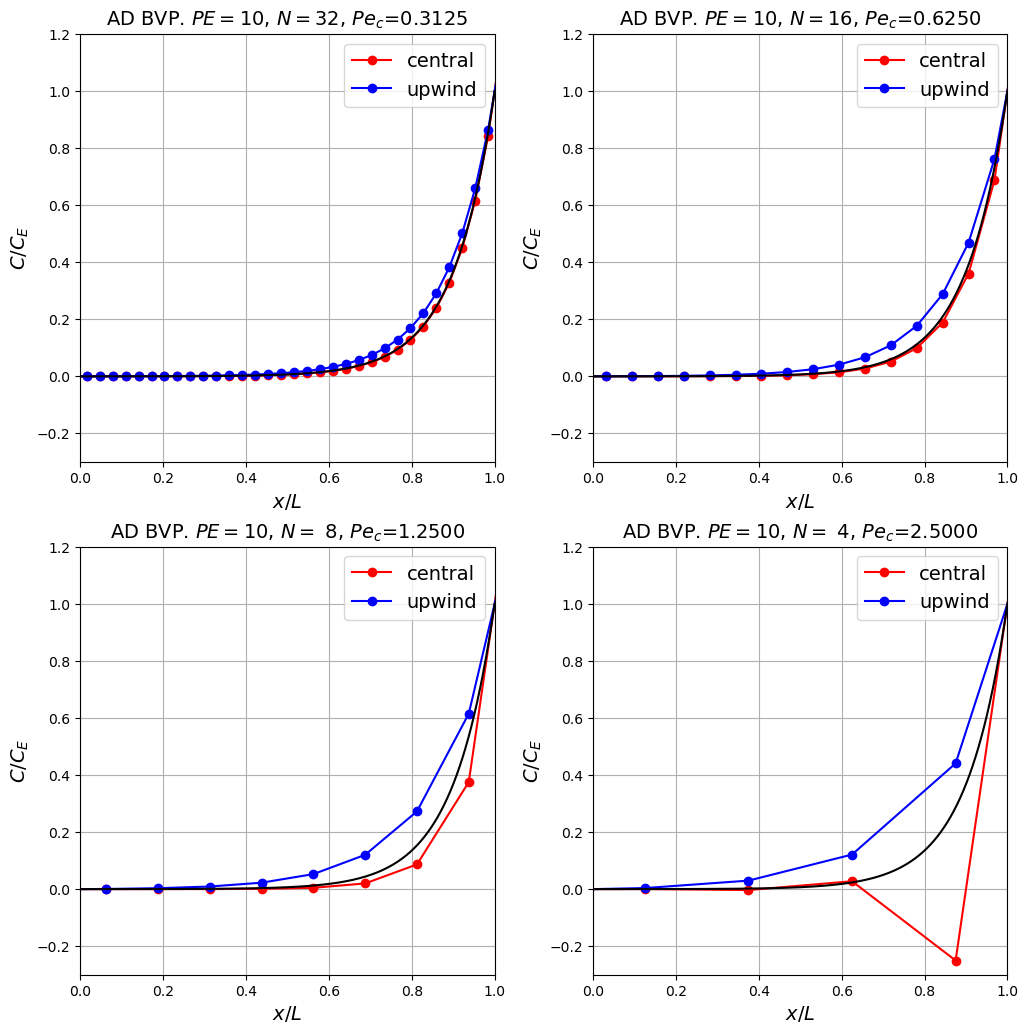

In [5]:
kappa = 0.005
L = 1
Pe = 10
U = Pe * kappa / L
CE = 1


def BVP_AD_upwind(L, U, kappa, CE, N):
    """ function to assemble and solve the AD BVP problem
    using central differences for both adv and diff
    """
    dx = L / N
    x = np.linspace(-dx / 2, dx / 2 + L, N + 2)
    A = np.zeros((N + 2, N + 2))
    b = np.zeros((N + 2))
    # interior points
    r_diff = kappa / dx**2
    r_adv = U / dx
    for i in range(1, N + 1):
        A[i, i - 1] = r_diff + r_adv
        A[i, i] = -2 * r_diff - r_adv
        A[i, i + 1] = r_diff
        b[i] = 0
    # BC1
    A[0, 0] = 0.5
    A[0, 1] = 0.5
    b[0] = 0
    # BC2
    A[N + 1, N] = 0.5
    A[N + 1, N + 1] = 0.5
    b[N + 1] = CE  # BC2
    # invert matrix
    C = np.linalg.solve(A, b)
    return x, C


# set up figure with 4 subplots to plot 4 resolutions
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# reshape so that we can iterate below over axs[i] instead of ax[i,j]
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=4)

# construct the exact solution on a fine mesh
xf = np.linspace(0, L, 1000)
Cex = CE * (np.exp(Pe * xf / L) - 1) / (np.exp(Pe) - 1)

# let's compute solution and plot for 4 different resolutions
for (i, N) in enumerate((32 * .5**np.arange(0, 4)).astype(int)):
    # call function to generate numerical solution
    x, C = BVP_AD_central(L, U, kappa, CE, N)
    axs[i].plot(x, C, 'ro-', label="central")
    x, C = BVP_AD_upwind(L, U, kappa, CE, N)
    axs[i].plot(x, C, 'bo-', label="upwind")
    axs[i].plot(xf, Cex, 'k')
    axs[i].set_xlabel('$x/L$', fontsize=14)
    axs[i].set_ylabel('$C/C_E$', fontsize=14)
    axs[i].set_title(
        'AD BVP. $PE = 10$, $N=$%2i, $Pe_c$=%.4f' % (N, U*(L/N)/kappa), fontsize=14)
    axs[i].legend(('numerical', 'exact'), loc='best', fontsize=14)
    # to exclude ghost points just restrict the x limit of the plot
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(-0.3, 1.2)
    axs[i].grid(True)
    axs[i].legend(loc='best', fontsize=14)

##### Observations


- The bad news is that as expected the upwind scheme is less accurate, and relatively speaking this gets worse as the resolution is changed due to the first-order vs second-order accuracy of the two schemes [see homework exercise].


- This manifests itself through enhanced (i.e. higher levels of) *numerical diffusion* with upwind methods, which can be particularly seen in it artificially thickening the width of the boundary layer, or equivalently limiting how fast the numerical solution can vary between grid points.


- The good news of course is that the scheme is stable (does not suffer from wiggles or undershoots) even when the mesh is very coarse (you could try coarsening it even further!) and the central scheme has gone unstable.

<br>


- **Important point:** What's the worse situation: (a) instability and obviously a solution we shouldn't make use of; or (b) a stable but potentially inaccurate result? In many ways (a) is "cleaner" - instability tells us we are asking too much of the simulation and we either need to use more resources (bigger computer or a longer runtime) or scale back our ambitions, but sometimes neither of these things is possible. Then we need to resort to (b), but this is only safe to do if we are aware and understand (and better yet can quantify) the consequences of the limitations to the method. Problems arise when people follow option (b) blindly, with no appreciation of the issues related to spurious numerical behaviour such as the numerical diffusion we've seen here.

#### Analysis of the upwind scheme [$\star$]
```{admonition} Optional Content
:class: dropdown
Returning to our Taylor series derivations of the different finite difference approximations above, specifically where we wrote

$$ \frac{f(x_0)-f(x_0-\Delta x)}{\Delta x} = f'(x_0) - \frac{\Delta x}{2} f''(x_0) + \mathcal{O}(\Delta x^2), $$

we can conclude that

$$ U\frac{c_i-c_{i-1}}{\Delta x} = Uc'_i - U\frac{\Delta x}{2} c''_i + \mathcal{O}(\Delta x^2).$$

Hence the leading order part of the *truncation error* between the exact and the (upwind) numerical representation of the advection term is

$$ Uc'_i - U\frac{c_i-c_{i-1}}{\Delta x} \approx  \frac{U\Delta x}{2} c''_i,$$

which qualitatively represents a diffusion-like term with a diffusivity coefficient of:

$$\kappa_{\text{num}} := \frac{U\Delta x}{2}.$$

This analysis of the leading order term in the error tells us that the numerical solution acts like the exact solution but with an error whose dominant component acts like diffusion - note that more generally this type of analysis is called a ***modified equation analysis*** and is useful in understanding the qualitative behaviour of different discretisations.  It tells us about an ODE/PDE that our numerical solution is actually in better agreement with than the actual problem we are trying to solve!!  
    
In this particular case our numerics are closer to the exact solution of a modified problem with extra diffusion!!

Note that the ratio of this numerical diffusion to the real physical diffusion is

$$\frac{\kappa_{\text{num}}}{\kappa} = \frac{U\Delta x}{2\kappa} = \frac{1}{2} Pe_c,$$

where 

$$Pe_C := \frac{U\Delta x}{\kappa},$$ 

is the grid or cell Peclet number we introduced above.

This new non-dimensional quantity can therefore be interpreted as telling us about the ratio of real to spurious diffusion in our upwind numerical solution.  

We clearly want the spurious numerical diffusion to be small in comparison to the true physical diffusion (otherwise we'd be essentially solving a completely different physical problem where the numerical diffusion would overwhelm the true diffusion), and so for accuracy we really require that 

$$ Pe_c \ll 1. $$

If $Pe_c$ approaches or even passes unity then the upwind scheme would be stable and give us a result, but it would potentially be completely wrong, especially in terms of representing phenomena where the mesh is too coarse to resolve rapid variations which may be present in the true solution.

Note that the stability limit of the cell Peclet number equalling two is the case where the ratio of real to spurious diffusion is one - i.e. the sizes of these two sources of diffusion in the solution are equivalent. Note that as we *additionally* include a discretisation of the physical diffusion in our problem this means that our overall discretisation is "double counting" diffusion - hence the reasons that in the example above our upwind solution is always too diffuse.
```

### Practicalities!

**Repeating what was said above (because it's very important):** 

***This is a very important point to remember - stability is of course a good thing, but it can lull you into a false sense of security as you can obtain a solution essentially to a different problem with very different qualitative and quantitative behaviour compared to the true solution.***

Just because you get a solution out of a model and it looks well-behaved (and perhaps even plausible based on what you know of the underlying physics), you cannot assume that it is accurate, especially if the solver makes use of inherently stable discretisation methods such as an upwind scheme - there is often no getting around the need for resolution (although subgrid scale parameterisations such as turbulence models do attempt to do this and very sophisticated/successful approaches have been developed, we won't have time to go into these in this module).

### Monotonicity


- Godunov (1959) showed that for linear discretisations, only first-order schemes can remain monotonic, which is known as [Godunov’s theorem](https://en.wikipedia.org/wiki/Godunov%27s_theorem):

"*Linear numerical schemes for solving PDE's, having the property of not generating new extrema (i.e. a monotone scheme), can be at most first-order accurate*"

<br>

- Higher-order linear schemes (e.g. the central scheme from above) will therefore always generate non-monotonic solutions if there is insufficient resolution - as we saw for the central scheme


- A popular solution is to use so-called *high-resolution schemes*. The idea with these is to use accurate schemes (i.e. > first-order) as much as possible, but revert to first-order schemes when gradients become too steep to avoid unphysical over- and undershoots. They do this by *limiting the fluxes*.  We'll come back to some of these ideas in a later lecture.

## Non-uniform (and adaptive) meshes [$\star\star$]
```{admonition} Advanced Content
:class: dropdown

- or getting resolution where you need it, ...


- or focusing your finite precious computational resource where it will be most effective (trying to optimise stability and solution accuracy vs computational cost).

We've seen above issues with wiggles (or instabilities) in our numerical solution, the presence and magnitude of these wiggles being a function of how large the solution gradient is, and this "largeness" being relative to the mesh resolution.

We've seen that the use of upwind based discretisations is *one* potential solution to deal with wiggles (but comes at the cost of a loss of accuracy).

The use of higher mesh resolution is another potential solution, but for efficiency reasons we ideally only want this higher resolution where (and when if the problem was also time-dependent) it is needed, and we ideally want to use coarse mesh resolution where and when it is sufficient.

But all of our code and derivations to date have been based on the assumption that the mesh size is uniform and fixed ($\Delta x = $ Constant, in both space and time).

We have two options to try and generalise this:


- (1) Use finite difference approximations for non-equidistant grids; these can be derived using the method of undetermined coefficients introduced above.


- (2) Apply a coordinate transformation to map between a non-equidistant grid and an equidistant grid.


Both have pros and cons, let's consider the coordinate transformations approach now.
```

### Coordinate transformations [$\star\star$]
```{admonition} Advanced Content
:class: dropdown
The idea here is to introduce a mapping between:


- *physical space* - the space our problem is actually posed within and thus the space by default we will attempt to discretise and solve our problem, e.g. $(x,y)$, and


- *computational space* - this is a space we transform our problem into to discretise and solve. 


There may be several motivations for this:


   1. It may allow us to simplify a complex physical geometry, e.g. simplifying our mesh generation and allowing us to use an orthogonal mesh and corresponding finite difference formulae/code.


   2. With the appropriate stretching, solving on a uniform mesh in computational space is equivalent to solving on a non-uniform mesh in physical space, again without the need for us to update our codes.
```

#### An example - an ocean domain [$\star\star$]
```{admonition} Advanced Content
:class: dropdown
To fix ideas let's consider an example.

Imagine we are interested in modelling a vertical slice in the ocean (i.e. an $(x,z)$ domain with a complex shaped bottom boundary - the bathymetry). Also be aware that interesting things tend to happen in the oceans near the top and the bottom so we may well be advised to concentrate our mesh resolution in these locations.
```

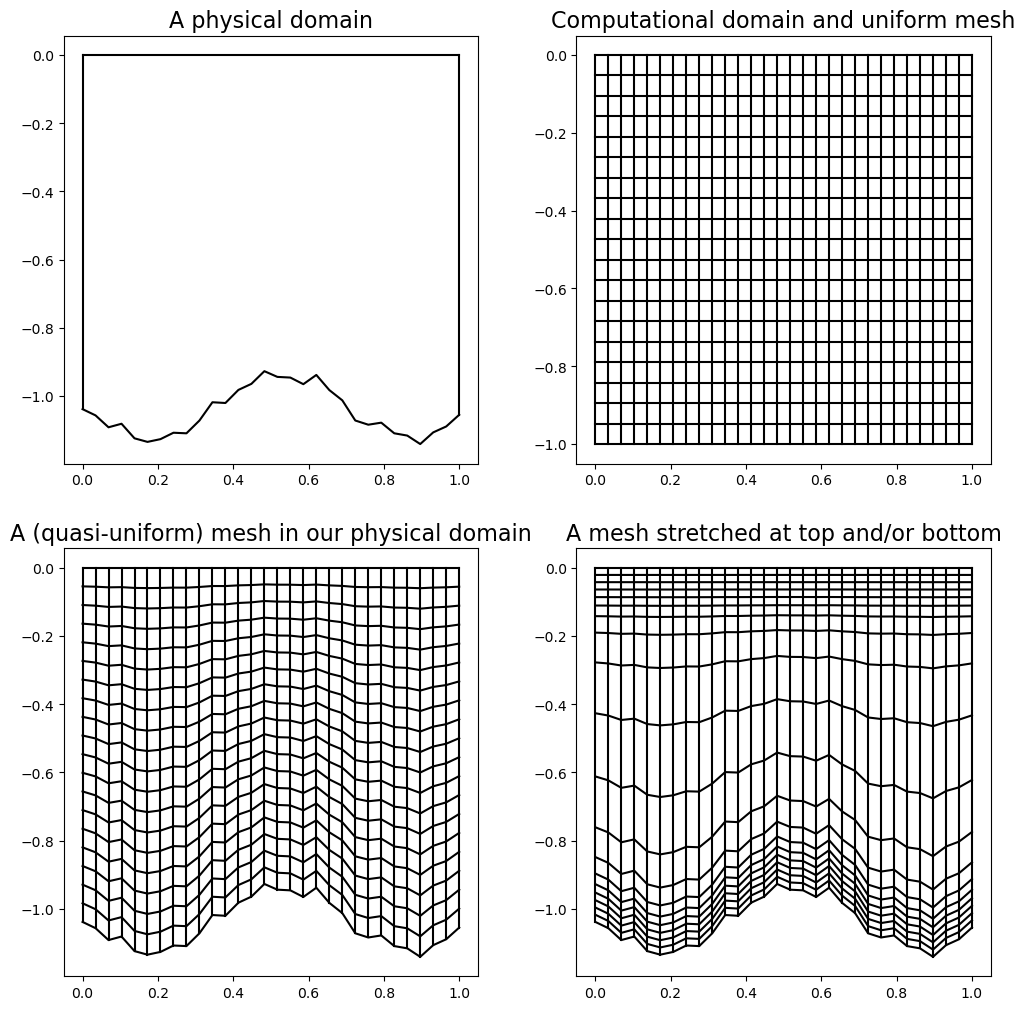

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=4)

# our physical domain - an ocean with z=0 at the top 
# and z = -bathy at bottom
x = np.linspace(0,1,30)
bathy = 1. + 0.1*np.sin(9*x) + 0.05*np.random.rand(len(x))
# plot domain boundaries
axs[0].plot(x,np.zeros_like(x),'k')
axs[0].plot(x,-bathy,'k')
axs[0].plot([x[0],x[0]], [-bathy[0], 0.],'k')
axs[0].plot([x[-1],x[-1]], [-bathy[-1], 0.],'k')
axs[0].set_title('A physical domain', fontsize=16)

# a computational domain and uniform regular mesh
# use same x as that used to generate bathy
z = np.linspace(-1,0,20)
xx, zz = np.meshgrid(x,z)

# function to plot mesh
def plot_mesh(xx, zz, ax):
    """ plot a finite difference mesh using points from xx, zz on axis ax
    """
    for i in range(xx.shape[0]):
        ax.plot(xx[i,:],zz[i,:],'k-')
    for j in range(xx.shape[1]):
        ax.plot(xx[:,j],zz[:,j],'k-')
        
plot_mesh(xx,zz,axs[1])
axs[1].set_title('Computational domain and uniform mesh', fontsize=16)

# scale computational mesh based on bathy
zzs = np.zeros_like(zz)
for j in range(len(x)):
    zzs[:,j] = zz[:,j]*bathy[j]
plot_mesh(xx,zzs,axs[2])
axs[2].set_title('A (quasi-uniform) mesh in our physical domain', fontsize=16)

# sometimes we want finer resolution at top and/or bottom
# can achieve this either with a different mesh in computational 
# domain, or by changing the mapping:
# for background see https://www.myroms.org/wiki/Vertical_S-coordinate
zzs2 = np.zeros_like(zz)
# stretching parameters
a = 10
b = 1
depth_c = 0.4
for j in range(len(x)):
    Cs = (1.-b) * np.sinh(a*zz[:,j]) / np.sinh(a) + \
         b*(np.tanh(a*( zz[:,j]+0.5))/(2*np.tanh(0.5*a)) - 0.5)  
    zzs2[:,j] = depth_c*zz[:,j] + (bathy[j] - depth_c)*Cs
    
plot_mesh(xx,zzs2,axs[3])
axs[3].set_title('A mesh stretched at top and/or bottom', fontsize=16);

### 1D theory  [$\star\star$]
```{admonition} Advanced Content
:class: dropdown
To keep things simple let's just focus on one dimension.

We introduce a mapping 

$$ x \equiv x(\xi), $$

between our physical coordinate $x$ and a computational coordinate $\xi$.

At the moment we are thinking about things in continuous space (we are going to transform our continuous problems, e.g. an ODE or PDE, into the computational domain), so think of $\,x\,$ here as a function which maps $\,\xi\,$ locations into $\,x\,$ locations. In particular, if and when we have a mesh point $\,\xi_i$, the corresponding mesh point location in physical space is defined as $\,x_i:=x(\xi_i)$.


<br>

To transform our differential equation we need to know how derivatives transform.

Recall that our model problem here is of the form

$$U\frac{\partial c}{\partial x} = \kappa\frac{\partial^2 c}{\partial x^2}, \;\;\;\; c(0) = 0, \;\;\;\; c(L)=c_E, $$

for the unknown function $c\equiv c(x)$.

If we now think of $\,x\,$ as being a function of $\,\xi\,$, then we have $\,c\equiv c(x(\xi))\,$ and we want/need to know the relationship between the $\,x\,$ derivatives of $\,c\,$ (as in our model problem definition), and the $\,\xi\,$ derivatives of $\,c\,$ which we need to know to solve the problem in computational space. 

This just involves use of the [chain rule](https://en.wikipedia.org/wiki/Chain_rule):

$$ \frac{d}{d\xi} c(x(\xi)) = \frac{dc}{dx} \frac{dx}{d\xi} = x_{\xi} \frac{dc}{dx}, $$

and again for second derivatives, now needing to make use of the [product rule](https://en.wikipedia.org/wiki/Product_rule):

$$
\frac{d^2}{d\xi^2} c(x(\xi)) & = \frac{d}{d\xi}\left(\frac{d}{d\xi} c(x(\xi))\right) = \frac{d}{d\xi} \left( x_{\xi} \frac{dc}{dx}\right)\;\;\;\text{(using the previous result)}\\
&= x_{\xi\xi} \frac{dc}{dx} +  x_{\xi}\frac{d}{d\xi} \left(\frac{dc}{dx}\right)= x_{\xi\xi} \frac{dc}{dx} + x_{\xi}^2\frac{d^2 c}{dx^2}\;\;\;\text{(using the previous result again)},
$$

and so rearranging these two relations we have

$$  \frac{dc}{dx} = \frac{1}{x_{\xi}}\frac{\partial c}{\partial \xi} \;\;\;\;\;\;\text{and}\;\;\;\;\;\;
\frac{d^2 c}{dx^2} = 
\frac{1}{x_{\xi}^2} \left( \frac{d^2 c}{d{\xi}^2} - {x_{\xi\xi}} \frac{d c}{d{x}}\right) =
\frac{1}{x_{\xi}^2} \left( \frac{d^2 c}{d{\xi}^2} - \frac{x_{\xi\xi}}{x_{\xi}} \frac{d c}{d{\xi}}\right). $$

Our differential equation can therefore be transformed into an equation posed in computational space:

$$U\frac{\partial c}{\partial x} = \kappa\frac{\partial^2 c}{\partial x^2}
\;\;\;\longrightarrow\;\;\;
\tilde{U}\frac{\partial c}{\partial \xi} = \tilde{\kappa}\frac{\partial^2 c}{\partial {\xi}^2},$$ 

i.e. of the same form as the original problem, but now with coefficients that take the form

$$\tilde{U}(\xi) := \frac{1}{x_{\xi}}  U + \frac{x_{\xi\xi}}{x_{\xi}^3}\kappa \;\;\;\;\;\;\;\text{and}\;\;\;\;\;\;\; \tilde{\kappa}(\xi):= \frac{1}{x_{\xi}^2}  \kappa. $$

So we now have to solve a linear ODE, with *variable coefficients*.
```

#### Choice of stretching function [$\star\star$]
```{admonition} Advanced Content
:class: dropdown
We will do this below, but to actually implement the code we need to choose the mapping between physical and computational space (i.e. $\,x\equiv x(\xi)$).

We have essentially infinite options here. Initially choosing $\,x\equiv\xi\,$ is a sensible verification test of course since our new code should recreate what we know worked previously, and being able to compare actual discretisation matrices etc provides extremely valuable debugging opportunities if needed!

Once we have checked the identity mapping works, let's consider a function which is able to concentrate resolution in the boundary layer - we want a uniform mesh in computational space to map to one where the physical mesh points are clustered close to the right-hand boundary of our domain.

An example of such a function is

$$ x = L \frac{\sinh^{-1}(\sinh(a)\xi)}{a}, $$

where, as we will see in the next plots, the parameter $a$ controls the degree of stretching.
```

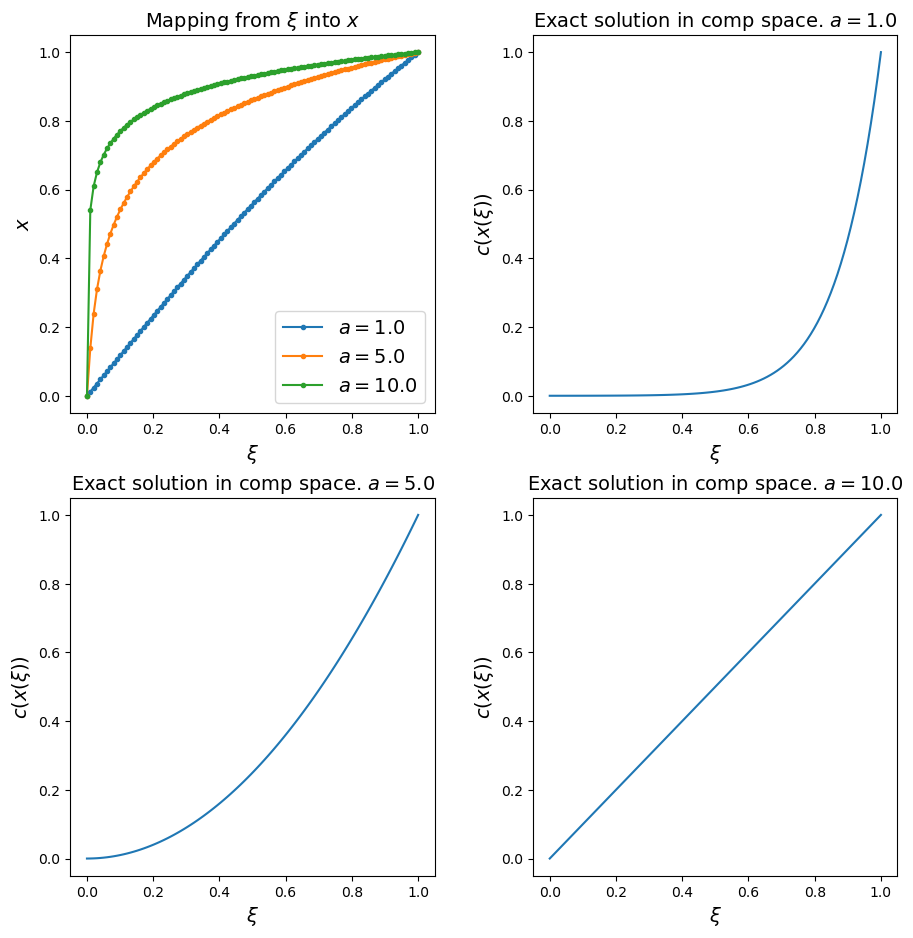

In [7]:
kappa = 0.005
L = 1
Pe = 10
U = Pe * kappa / L
CE = 1

# implement the function above
def stretch_func(xi, a):
    x = L * np.arcsinh(np.sinh(a)*xi)/a
    return x

# create a uniform mesh on computational space
xi = np.linspace(0,L,100)

# plot
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=4)
for i, a in enumerate(np.array([1.,5.,10.])):
    x = stretch_func(xi,a)
    axs[0].plot(xi, x, '.-', label='$a={0:.1f}$'.format(a))
    # plot the exact solution mapped to computational space
    axs[i+1].plot(xi, CE * (np.exp(Pe * x / L) - 1) / (np.exp(Pe) - 1))
    axs[i+1].set_xlabel(r'$\xi$', fontsize=14)
    axs[i+1].set_ylabel(r'$c(x(\xi))$', fontsize=14)
    axs[i+1].set_title('Exact solution in comp space. $a={0:.1f}$'.format(a), fontsize=14)
                  
axs[0].set_xlabel(r'$\xi$', fontsize=14)
axs[0].set_ylabel('$x$', fontsize=14)
axs[0].set_title(r'Mapping from $\xi$ into $x$', fontsize=14)
axs[0].legend(loc='best', fontsize=14);

##### Observations


- the larger the value for $a$ the more resolution is focused in the boundary layer 


- $a=1$ yields the identity mapping


- if we plot the exact solution *in computational space* we see that the more we stretch the coordinate the more gentle the behaviour of the solution in computational space - as we will be solving our problem on a uniform mesh in computational space, we have to imagine that this will do good things for both stability and accuracy!


### Implementation [$\star\star$]
```{admonition} Advanced Content
:class: dropdown
As you will see below, the implementation is very similar to our previous code (as it should be as we are solving the same equation still on a uniform mesh), but now we additionally need to compute the variable coefficients.
```

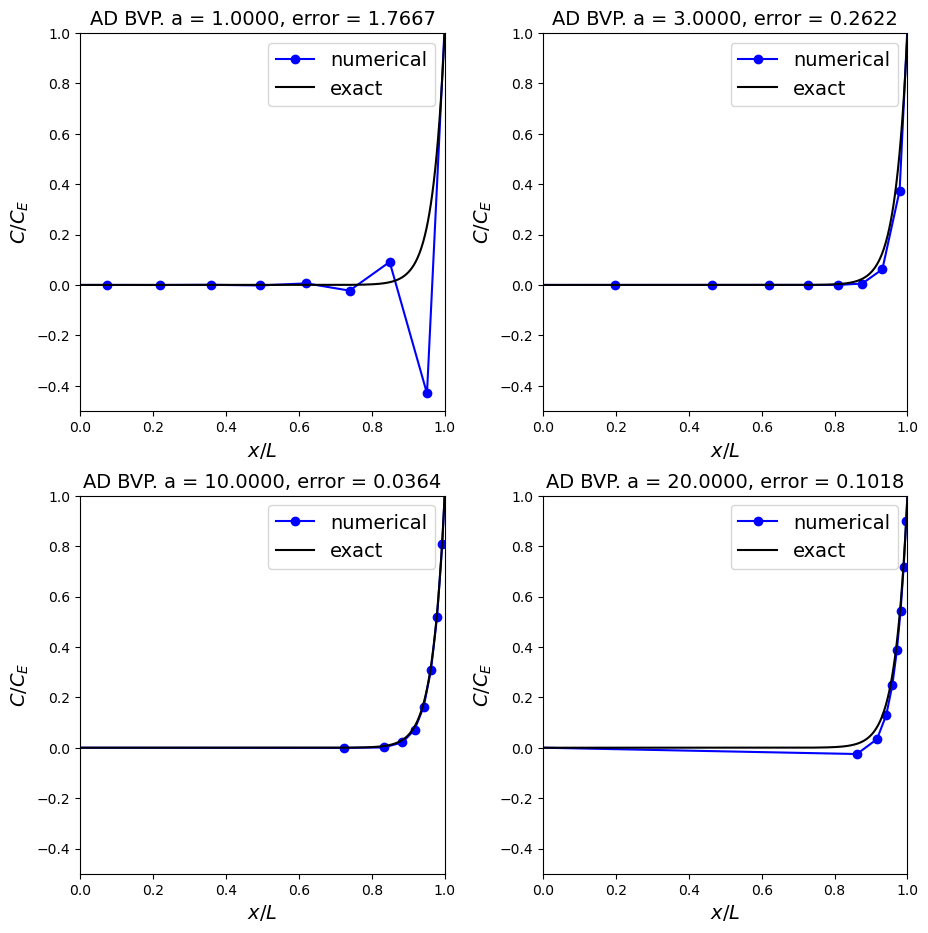

In [8]:
L = 1.
U = 1.
Pe = 30.
kappa = 1./Pe
CE = 1.

def BVP_AD_central_stretch_mesh(L, U, kappa, CE, N, Xfn):
    """ function to assemble and solve the AD BVP problem
    using central differences for both adv and diff
    with a mesh stretching given by the function Xfn
    """
    dxi = 1. / N
    xi = np.linspace(-dxi / 2, dxi / 2 + 1, N + 2)
    x = Xfn(xi)
    kappat = np.zeros_like(x)
    Ut = np.zeros_like(x) 
    for i in range(1, N + 1):
        Xxi = (x[i+1] - x[i-1]) / (2 * dxi)
        Xxixi = (x[i+1] - 2*x[i] + x[i-1]) / dxi**2
        Ut[i] = (1. / Xxi) * U + (Xxixi / (Xxi**3)) * kappa
        kappat[i] = (1. / Xxi**2) * kappa      
    A = np.zeros((N + 2, N + 2))
    b = np.zeros((N + 2))
    # interior points
    for i in range(1, N + 1):
        A[i, i - 1] = kappat[i] / (dxi**2) + 0.5 * Ut[i] / dxi
        A[i, i] = -2. * kappat[i] / dxi**2
        A[i, i + 1] = kappat[i] / (dxi**2) - 0.5 * Ut[i] / dxi
        b[i] = 0
    # BC1
    A[0, 0] = 0.5
    A[0, 1] = 0.5
    b[0] = 0
    # BC2
    A[N + 1, N] = 0.5
    A[N + 1, N + 1] = 0.5
    b[N + 1] = CE  
    # invert matrix
    C = np.linalg.solve(A, b)
    return x, C

# construct the exact solution
xf = np.linspace(0, L, 1000)
Cex = CE * (np.exp(Pe * xf / L) - 1) / (np.exp(Pe) - 1)

# set up figure with 4 subplots to plot 4 resolutions
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=4)

# let's use a relatively small number of grid points
N = 8
# define the function to generate numerical solution
Xfn = lambda xi: L * np.arcsinh(np.sinh(a)*xi)/a
for i, a in enumerate([1,3,10,20]):
    x, C = BVP_AD_central_stretch_mesh(L, U, kappa, CE, N, Xfn)
    axs[i].plot(x, C, 'bo-', xf, Cex, 'k')
    axs[i].set_xlabel('$x/L$', fontsize=14)
    axs[i].set_ylabel('$C/C_E$', fontsize=14)
    axs[i].set_title('AD BVP. a = {0:.4f}, error = {1:.4f}'.
                     format(a,np.linalg.norm(C - CE * (np.exp(Pe * x / L) - 1) / (np.exp(Pe) - 1))), fontsize=14)
    axs[i].legend(('numerical', 'exact'), loc='best', fontsize=14)
    # to exclude ghost points just restrict the x limit of the plot
    axs[i].set_xlim(0, 1);
    axs[i].set_ylim(-.5, 1);

##### Observations

So with the correct mesh spacing not only can we recover a stable solution, if we are very careful we can optimise the mesh to attain, relatively speaking, a very accurate result for low computational cost!



### Optimisation [$\star\star$]
```{admonition} Advanced Content
:class: dropdown
Let's try to optimise this - i.e. let's vary $a$ and see its effect on error.  Note that this process won't be possible in general since we won't have access to the exact solution so we would need to come up with other approaches to select $a$, or more generally the transformation function.
```

Uniform mesh (a = 1) gives an error of 1.766687
Minimum error of 0.036023 when a = 10.600000


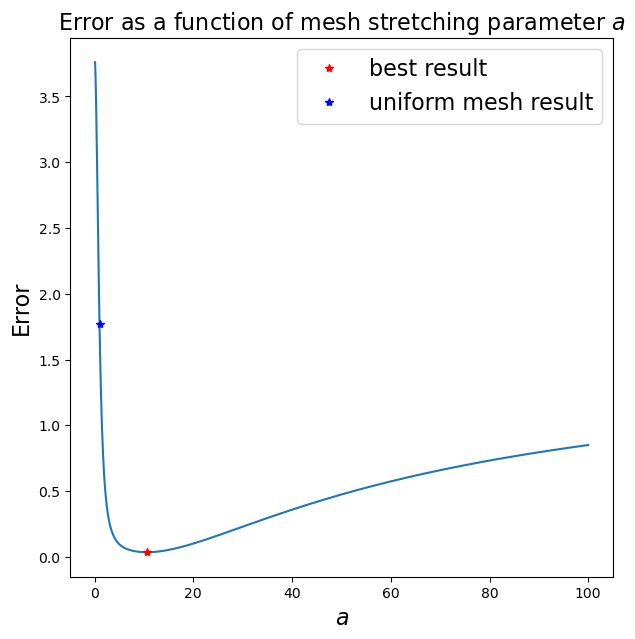

In [9]:
L = 1.
U = 1.
Pe = 30.
kappa = 1./Pe
CE = 1.

# let's use a relatively small number of grid points
N = 8
# mesh stretching values to test
aa = np.linspace(0.1,100.,1000)
# define function to generate numerical solution
Xfn = lambda xi: L * np.arcsinh(np.sinh(a)*xi)/a
errors = np.zeros_like(aa)
for i, a in enumerate(aa):
    x, C = BVP_AD_central_stretch_mesh(L, U, kappa, CE, N, Xfn)
    errors[i] = np.linalg.norm(C - CE * (np.exp(Pe * x / L) - 1) / (np.exp(Pe) - 1))

a = 1.
x, C = BVP_AD_central_stretch_mesh(L, U, kappa, CE, N, Xfn)
uniform_error = np.linalg.norm(C - CE * (np.exp(Pe * x / L) - 1) / (np.exp(Pe) - 1))
print('Uniform mesh (a = 1) gives an error of {0:.6f}'.format(uniform_error))
besti = np.argmin(errors)
print('Minimum error of {0:.6f} when a = {1:.6f}'.format(errors[besti], aa[besti]))
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
ax1.plot(aa,errors)
ax1.set_xlabel('$a$', fontsize=16)
ax1.set_ylabel('Error', fontsize=16)
ax1.set_title('Error as a function of mesh stretching parameter $a$', fontsize=16);
ax1.plot([aa[besti]], [errors[besti]], 'r*', label='best result')
ax1.plot([1.0], [uniform_error], 'b*', label='uniform mesh result')
ax1.legend(loc='best',fontsize=16);

##### Comments

- Note that if you vary $N$ above, $a \approx 10$ is always a good choice.


- The optimal stretching is (hopefully obviously) a function of $Pe$, e.g. for $Pe=10$ a value of $a=4$ is closer to optimal.

## The time-dependent (unsteady) advection-diffusion problem

Let's return to the time-dependent, or unsteady, form of the [*advection-diffusion* (or sometimes *convection-diffusion*)](https://en.wikipedia.org/wiki/Convection%E2%80%93diffusion_equation) probklem

$$\frac{\partial c}{\partial t} + U\frac{\partial c}{\partial x} = \kappa\frac{\partial^2 c}{\partial x^2}, $$

with initial and boundary conditions

$$c(x,0)=c^0(x),  \;\;\;\;\;\; c(0,t) = 0, \;\;\;\;\;\; c(L,t)=c_E$$

<br>

Recalling again that the Peclet number

$$ Pe = \frac{UL}{\kappa}, $$ 

still describes the relative importance of advection to diffusion.

### Discretising in space

Recall the *method of lines* approach which invovled discretising in space first to form a coupled system of ODEs.

<br>

Using central differences in space for both advection and diffusion (remembering that there are potential stability concerns with the use of a central difference for advection!!), 
at location $x_i$ the discretised form of the PDE tells us that

$$ 
\frac{\partial c_i}{\partial t} = \kappa\frac{c_{i+1} - 2c_i + c_{i-1}}{\Delta x^2} - U\frac{c_{i+1} - c_{i-1}}{2\Delta x}  , $$

where 

$$c_i \equiv c_i(t) \approx c(x_i,t). $$

and since we have used central schemes for both advection and diffusion the spatial truncation error is $\mathcal{O}({\Delta x^2})$. 



#### Including Dirichlet boundary conditions

We need to consider appropriate boundary conditions for this problem, and here for simplicity we can initially just use exactly the same discretised boundary conditions as we did when we considered the corresponding BVP:

$$
x=0: & \;\;\;\; \frac{1}{2}(c_0 + c_1) = 0, \\[5pt]
x=L: & \;\;\;\; \frac{1}{2}(c_N + c_{N+1}) = c_E,
$$

for a given value $c_E$.

<br>

In order to formulate these as ODEs to add in to our ODE system above, we differentiate:


$$
\frac{1}{2}(c_0 + c_1) &= 0 \;\;\;\;\implies\;\;\;\; \frac{1}{2}\left(\frac{d c_0}{d t} + \frac{d c_1}{d t}\right) = 0, \\[5pt]
\frac{1}{2}(c_N + c_{N+1}) &= c_E \;\;\;\;\implies\;\;\;\; \frac{1}{2}\left(\frac{d c_N}{d t} + \frac{d c_{N+1}}{d t}\right) = \frac{d c_E}{d t}\;\;\; \text{(which we assume to be zero)}.
$$


We therefore have two extra ODEs for the two ghost nodes, but note that they're not at the moment quite in the simple form $\frac{d{\boldsymbol{c}}}{dt} = \boldsymbol{f}\,(t,\boldsymbol{c}(t))$, but we will see below how we deal with this.

We need to specify corresponding initial conditions, which we can obtain simply by evaluating the BC at the initial time (which we assume it $t=0$) to yield

$$
\frac{1}{2}(c_0(t=0) + c_1(t=0)) &= 0 \;\;\;\;\implies\;\;\;\; c_0^0 = -c_1^0, \\[5pt]
\frac{1}{2}(c_N(t=0) + c_{N+1}(t=0)) &= c_E \;\;\;\;\implies\;\;\;\;  c_{N+1}^0 =  2c_E - c_N^0.
$$

#### The (semi-) discretised system

Our ***semi-discretised system*** thus takes the form

$$
  \begin{cases}
\frac{1}{2}(c_0 + c_1) &= 0 \\[5pt]
\frac{\partial c_1}{\partial t}  & = \kappa\frac{c_{2} - 2c_1 + c_{0}}{\Delta x^2} -  U\frac{c_{2} - c_{0}}{2\Delta x} \\[5pt]
\vdots \\[5pt]
\frac{\partial c_N}{\partial t}  & = \kappa\frac{c_{N+1} - 2c_N + c_{N-1}}{\Delta x^2} -  U\frac{c_{N+1} - c_{N-1}}{2\Delta x} \\[5pt]
\frac{1}{2}(c_N + c_{N+1}) &= c_E,
  \end{cases}
$$


[It's really just a matter of style if we use ${\partial c_i}/{\partial t}$ or ${d c_i}/{d t}$ here since recall that $c_i \equiv c_i(t)$ - i.e. we only now have time as a proper independent variable.]

At the moment this system comprises $N$ coupled ODEs, coupled to two algebraic conditions representing the two boundary conditions.

A general ODE solver won't necessarily be able to deal with the algebraic conditions, as they are likely set-up to solve systems given in the form

$$\frac{d{\boldsymbol{c}}}{dt} = \boldsymbol{f}\,(t,\boldsymbol{c}(t)),\;\;\;\;\;\; \boldsymbol{c}\,(0)=\boldsymbol{c}^0.$$

<br>

[Note that ***differential-algebraic equation (DAE) solvers*** do exist (e.g. *DASSL*: <https://www.osti.gov/biblio/5882821-description-dassl-differential-algebraic-system-solver>), we just won't consider them here].

<br>


However, we can convert this into a system of $N+2$ coupled ODEs fairly easily.  

To achiece this, let's first differentiate the semi-discrete boundary conditions in time:

$$
\frac{1}{2}(c_0 + c_1) &= 0 \;\;\;\;\implies\;\;\;\; \frac{1}{2}\left(\frac{d c_0}{d t} + \frac{d c_1}{d t}\right) = 0, \\[5pt]
\frac{1}{2}(c_N + c_{N+1}) &= c_E \;\;\;\;\implies\;\;\;\; \frac{1}{2}\left(\frac{d c_N}{d t} + \frac{d c_{N+1}}{d t}\right) = \frac{d c_E}{d t}.
$$

For simplicity here we will assume that our boundary condition $c_E$ is constant in time and so the RHS of the second equation is also zero, this could easily be generalised.

We therefore have two extra ODEs for the two ghost nodes. 

They're not at the moment quite in the simple form $\frac{d{\boldsymbol{c}}}{dt} = \boldsymbol{f}\,(t,\boldsymbol{c}(t))$, but we will see below how we deal with this.

Being ODEs we do of course need corresponding initial conditions. We know that we want the BCs to hold at all time levels, and so we can just evaluate the BC at the initial time (which we assume it $t=0$) to yield

$$
\frac{1}{2}(c_0(t=0) + c_1(t=0)) &= 0 \;\;\;\;\implies\;\;\;\; c_0^0 = -c_1^0, \\[5pt]
\frac{1}{2}(c_N(t=0) + c_{N+1}(t=0)) &= c_E \;\;\;\;\implies\;\;\;\;  c_{N+1}^0 =  2c_E - c_N^0.
$$

### The semi-disrete matrix system

Now that we've dealt with the BCs, the semi-discrete ODE system can be written as

$$M \, \frac{d\boldsymbol{c}}{dt} = B \, \boldsymbol{c},$$

where

$$
\boldsymbol{c} & := \begin{pmatrix}
c_0\\
c_1\\
\vdots\\
c_N\\
c_{N+1}
\end{pmatrix},
\;\;\;\;\;\;\;\;\;\;\;\;
M := \begin{pmatrix}
    \frac{1}{2} & \frac{1}{2} & 0 & \cdots & \cdots  & 0 \\
    0 & 1 & 0 & \ldots &   & 0 \\    
    \vdots &  &  & \ddots &   & 0 \\  
       &  &  & 0  &  1 & 0 \\  
    0 & \cdots &  & 0 & \frac{1}{2}  & \frac{1}{2}
\end{pmatrix},
\\[10pt]
B & := \begin{pmatrix}
    0 & 0 & 0 & \ldots & \dots  & 0 \\
    \left\{r_{\text{diff}} + r_{\text{adv}}\right\} & \left\{-2r_{\text{diff}}\right\} & \left\{r_{\text{diff}} - r_{\text{adv}}\right\} & 0 & & \vdots \\
    0 & \ddots & \ddots & \ddots &  & \vdots \\
    \vdots &  &  &  &  & 0 \\
      &  & 0 &\left\{r_{\text{diff}}+r_{\text{adv}}\right\} & \left\{-2r_{\text{diff}}\right\} & \left\{r_{\text{diff}} - r_{\text{adv}}\right\}\\    
    0 & \ldots & \ldots & 0 & 0  & 0
\end{pmatrix},
$$

and we have used the shorthand notation

$$r_{\text{adv}} := \frac{U}{2\Delta x}, \;\;\;\;\;\;\;\; r_{\text{diff}} := \frac{\kappa}{\Delta x^2}.$$

The matrix $M$ is present here because of the form of our BCs.

This isn't quite in the form we need for a general ODE solver, but this is easily rectified by simply multiplying through by the inverse of $M$:


$$\frac{d\boldsymbol{c}}{dt} = M^{-1} \, B \, \boldsymbol{c},$$

which is in the form 

$$\frac{d\boldsymbol{c}}{dt} = A \, \boldsymbol{c},$$

where $A := M^{-1} \, B$.

Let's form these spatial discretisation matrices for a small problem to check what they look like.

In [10]:
# physical parameters
Pe = 5
L = 1
U = 1
CE = 1
kappa = 1/Pe

# define spatial mesh
N = 5
dx = L / N
x = np.linspace(-dx / 2, dx / 2 + L, N + 2)

# find the RHS discretisation matrices

# define first the parameters we defined above
r_diff = kappa / dx**2
r_adv = 0.5 * U / dx

# and use them to create the B matrix - recall zeros on the first and last rows
B = np.zeros((N + 2, N + 2))
for i in range(1, N + 1):
    B[i, i - 1] = r_diff + r_adv
    B[i, i] = -2 * r_diff
    B[i, i + 1] = r_diff - r_adv

# create M matrix - start from the identity
M = np.eye(N + 2)
# and fix the first and last rows
M[0,(0,1)] = [0.5, 0.5]
M[-1,(-2,-1)] = [0.5, 0.5]   
    
# find A matrix
A = np.linalg.inv(M) @ B

print('B = ')
pprint(B)
print('\nM = ')
pprint(M)
print('\nA = ')
pprint(A)

B = 


NameError: name 'pprint' is not defined

Let's turn the assembly of the RHS discretisation matrix ($A$) into a function for use later.

In [ ]:
def assemble_adv_diff_disc_matrix_central(U, kappa, L, N):
    """ Function to form the spatial discretisation matrix for 
    advection-diffusion using central differences, given physical 
    parameters U and kappa and assuming a uniform mesh of N interior 
    nodes on the interval [0,L] with the ghost node approach.
    
    Returns the discretisation matrix A as well as the mesh x.
    """
    # define spatial mesh
    dx = L / N
    x = np.linspace(-dx / 2, dx / 2 + L, N + 2)
    # define first the parameters we defined above
    r_diff = kappa / dx**2
    r_adv = 0.5 * U / dx

    # and use them to create the B matrix - recall zeros on the first and last rows
    B = np.zeros((N + 2, N + 2))
    for i in range(1, N + 1):
        B[i, i - 1] = r_diff + r_adv
        B[i, i] = -2 * r_diff
        B[i, i + 1] = r_diff - r_adv

    # create M matrix - start from the identity
    M = np.eye(N + 2)
    # and fix the first and last rows
    M[0,(0,1)] = [0.5, 0.5]
    M[-1,(-2,-1)] = [0.5, 0.5]   

    # find A matrix
    A = np.linalg.inv(M) @ B
    return A, x

### Discretising in time

We have a few options now. One is to just hand over this system to a "black box" ODE solver, the other is for us to take charge of the time-stepping task ourselves.

Firstly we prescribe a time step size $\Delta t$ which allows us to now define the "space-time mesh"

```{figure} Images/Lecture11.1/space_time_stencil.svg
:width: 70%
```    

where


$$
x_i & := \left( i - \frac{1}{2}\right) \, \Delta x,   \;\;\;\;\textrm{for}\;\;\;\;  i=0,\ldots,N+1\\[5pt]
t^n & := n\,\Delta t \;\;\;\;\textrm{for}\;\;\;\;  n=0,1,\ldots
$$

#### Forward Euler

Let's implement the simplest method we know - forward Euler.

And let's start from an initial condition given by the solution to the diffusion only problem (i.e. the linear solution joining the two BC values).

In [ ]:
# physical parameters
Pe = 5
L = 1
U = 1
CE = 1
kappa = 1/Pe

# define number of points in spatial mesh (N+2 including ghose nodes)
N = 40

# use the function we just wrote to form the spatial mesh and the discretisation matrix 
A, x = assemble_adv_diff_disc_matrix_central(U, kappa, L, N)

# define a time step size
dt = 0.001

# and compute and print some key non-dimensional parameters - we'll explain these later
dx = L / N
print('Pe_c: {0:.5f}'.format(U*dx/kappa))
print('CFL: {0:.5f}'.format(U*dt/dx))
print('r: {0:.5f}'.format(kappa*dt/(dx**2)))

# define the end time and hence some storage for all solution levels
tend = 1
# assume a constant dt and so can define all the t's in advance
t = np.arange(0, tend, dt)
# and we can also set up a matrix to store the discrete solution in space-time
# with our a priori knowledge of the size required.
C = np.empty((len(x),len(t)))

# define an initial condition - this one just linearly varies between the BC values, 
# i.e. 0 and 1 - this linear solution is also the steady state solution to the diffusion 
# only problem of course.
# Let's place this discrete solution in the first column of the C matrix which stores all solution levels
C[:,0] = CE * x / L

# now let's do the time-stepping via a for loop
# we will need the identity matrix so define it once outside the loop
I = np.eye(len(x))
for n in range(len(t)-1):
    C[:,n+1] = (I + A * dt) @ C[:, n]
    

# construct the exact solution to the **steady state** problem
xf = np.linspace(0, L, 1000)
Cex = CE * (np.exp(Pe * xf / L) - 1) / (np.exp(Pe) - 1)

# set up figure
fig = plt.figure(figsize=(7, 7))
ax1 = plt.subplot(111)
ax1.set_xlabel('$x/L$', fontsize=16)
ax1.set_ylabel('$C/C_E$', fontsize=16)
ax1.set_title('Adv-Diff time-dependent PDE solve', fontsize=16)
# plot the exact solution to the steady state version of problem
ax1.plot(xf, Cex, 'k', lw = 3, label = 'exact steady state solution')

# let's plot every 100th time level
for i in np.arange(5,len(t),100):
    ax1.plot(x, C[:,i], '.-')

ax1.legend(loc='best', fontsize=14)
# to exclude ghost points just restrict the x limit of the plot
ax1.set_xlim(0, 1);

In [ ]:
# create an animation

from matplotlib import animation
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111, xlim=(0, 1), ylim=(-0.1, 1.1),
                      xlabel='$x$', ylabel='$C$',
                      title='Advection-Diffusion - convergence to the steady state solution')
# if we don't close the figure here we get a rogue frame under the movie
plt.close()

ax1.plot(xf, Cex, 'k', lw=3, label='exact ss solution')
line, = ax1.plot([], [], 'b', lw=3, label='transient numerical solution')
time_text = ax1.text(0.78, 0.95, '', transform=ax1.transAxes)
ax1.legend(loc='upper left', fontsize=14)


def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(i):
    line.set_data(x, C[:, i])
    time_text.set_text('time = {0:.3f}'.format(i*dt))
    return line, time_text


number_frames = 100
frames = np.arange(0, C.shape[1], int(len(t)/number_frames))
anim = animation.FuncAnimation(fig, animate, frames,
                               interval=20, blit=True, init_func=init)

HTML(anim.to_jshtml())

##### Observations


- We chose here to use the initial condition from the diffusion-only steady state problem, i.e. a linear function which passes through the two boundary values, in part since its simple and since it has a physical basis.


- The black line is the exact solution of the steady-state advection-diffusion problem we saw from the BVP section.


- We can see from above that this time-dependent PDE is an example of a case where the unsteady problem converges in time to the steady solution, i.e. the steady solution represents the long-term behaviour of the transient unsteady problem.


- We note also that this looks to be a stable solver ...

<br>

- **or at least we have selected numerical parameters that ensure that we remain stable - since we have used a central difference for advection and a forward Euler scheme in time (both of which we saw in previously were prone to going unstable unless we're careful over the choice of $\Delta x$ and $\Delta t$), this is indeed the case here.**

<br>

- **We will lose stability if we make either $\Delta x$ or $\Delta t$ too large (relative to the underlying physics of the problem) - you can experiment with these numerical parameters to confirm this, or equivalently play with the physical parameters such as $U$ or $Pe$ to make the problem more challenging - remember that whether or not $\Delta x$ or $\Delta t$ are sufficiently fine is a relative consideration which is dependent on the spatial and temporal scales of the problem, which here are governed by $U$ and $Pe$ (or $\kappa$)!**

<br>

- This is the cell Peclet number stability criteria for the steady state version of this problem from earlier - try implementing an solver that uses upwind for advection (see homework question).

### Example - advection-diffusion of a Gaussian

The previous problem was dominated by the boundary conditions.

Let's now consider a problem where a "blob" is advecting and diffusing in the interior of the domain, i.e. let's consider dynamics away from the boundaries.

In [ ]:
# physical parameters
Pe = 100
L = 1
U = 1
kappa = 1/Pe
# set the RHS boundary value to zero as well as the left
CE = 0


# define number of points in spatial mesh (N+2 including ghose nodes)
N = 100

# use the function we just wrote to form the spatial mesh and the discretisation matrix 
A, x = assemble_adv_diff_disc_matrix_central(U, kappa, L, N)

# define a time step size
dt = 0.0002

# and compute and print some key non-dimensional parameters
dx = L / N
print('Pe_c: {0:.5f}'.format(U*dx/kappa))
print('CFL: {0:.5f}'.format(U*dt/dx))
print('r: {0:.5f}'.format(kappa*dt/(dx**2)))

# define the end time and hence some storage for all solution levels
tend = 1
# assume a constant dt and so can define all the t's in advance
t = np.arange(0, tend, dt)
# and we can also set up a matrix to store the discrete solution in space-time
# with our a priori knowledge of the size required.
C = np.empty((len(x),len(t)))

# define an initial condition - a "blob" in the shape of a Gaussian
# and place it in the first column of the C matrix which stores all solution levels
C[:, 0] = np.exp(-((x-0.2)/0.05)**2)

# now let's do the time-stepping via a for loop
# we will need the identity matrix so define it once outside the loop
I = np.eye(len(x))
for n in range(len(t)-1):
    C[:,n+1] = (I + A * dt) @ C[:, n]
    

# set up figure
fig = plt.figure(figsize=(7, 7))
ax1 = plt.subplot(111)
ax1.set_xlabel('$x/L$', fontsize=16)
ax1.set_ylabel('$C/C_E$', fontsize=16)
ax1.set_title('Adv-Diff time-dependent PDE solve', fontsize=16)

# let's plot every 500th time level
for i in np.arange(0,len(t),500):
    ax1.plot(x, C[:,i], '.-')


# to exclude ghost points just restrict the x limit of the plot
ax1.set_xlim(0, 1);

##### Observations

- So the Gaussian is clearly advecting (translating to the right) and diffusing (getting shorter and fatter)!


- Something that looks a little strange (it is still physically meaningful) happens when it hits the boundary due to the constraint of the Dirichlet BCs.


- Next let's see how to implement *periodic BCs*. 

### Periodic boundaries

Periodic boundaries, or boundary conditions, are useful since they effectively mean we can run a simulation indefinitely without an externally imposed boundary condition (e.g. of Dirichlet or Neumann type) impacting on the result. Essentially what goes out one end automatically comes in the other!

So here for this advection diffusion example instead of using our Dirichlet boundary conditions in our disretisation matrix, now we want to effectively loop our domain.

We can thus do away with the ghost nodes which we used to allow us to formulate a finite difference expression at the boundary, and where needed instead of using these ghost nodes, use the appropriate nodal values from the other end of the domain. 

Topologically you can think of the mesh as being a circle.

Since we don't have/need the ghost nodes anymore, we locate our $N$ interior nodes such that the first and last correspond to the end point of our domain, i.e. we replace

```Python
x = np.linspace(-dx / 2, dx / 2 + L, N + 2)
```
with
```Python
x = np.linspace(0, L, N)
```

What this means for our discrete system is that our old $B$ matrix of dimension ($N+2 \, \times \, N+2$, where $N$ was the number of internal nodes)

$$
B  := \begin{pmatrix}
    0 & 0 & 0 & \ldots & \dots  & 0 \\
    \left\{r_{\text{diff}} + r_{\text{adv}}\right\} & \left\{-r_{\text{diff}}\right\} & \left\{r_{\text{diff}} - r_{\text{adv}}\right\} & 0 & & \vdots \\
    0 & \ddots & \ddots & \ddots &  & \vdots \\
    \vdots &  &  &  &  & 0 \\
      &  & 0 &\left\{r_{\text{diff}}+r_{\text{adv}}\right\} & \left\{-r_{\text{diff}}\right\} & \left\{r_{\text{diff}} - r_{\text{adv}}\right\}\\    
    0 & \ldots & \ldots & 0 & 0  & 0
\end{pmatrix},
$$

where we hadn't yet included the boundary discretisation (which recall led to entries in the first and last column corresponding to the ghost nodes), can be generalised to the $N\times N$ matrix

$$
B  := \begin{pmatrix}
    \left\{-r_{\text{diff}}\right\} & \left\{r_{\text{diff}} - r_{\text{adv}}\right\} & 0 & \ldots & \dots  & \left\{r_{\text{diff}} + r_{\text{adv}}\right\} \\
    \left\{r_{\text{diff}} + r_{\text{adv}}\right\} & \left\{-r_{\text{diff}}\right\} & \left\{r_{\text{diff}} - r_{\text{adv}}\right\} & 0 & & \vdots \\
    0 & \ddots & \ddots & \ddots &  & \vdots \\
    \vdots &  &  &  &  & 0 \\
      &  & 0 &\left\{r_{\text{diff}}+r_{\text{adv}}\right\} & \left\{-r_{\text{diff}}\right\} & \left\{r_{\text{diff}} - r_{\text{adv}}\right\}\\    
    \left\{r_{\text{diff}} - r_{\text{adv}}\right\} & \ldots & \ldots & 0 &\left\{r_{\text{diff}}+r_{\text{adv}}\right\} & \left\{-r_{\text{diff}}\right\}
\end{pmatrix}.
$$

As we'll be using discretisations of advection and diffusion in periodic domains multiple times below let's implement functions for these matrices individually.  Also note that in these examples we don't multiply through by the $r_{\text{adv}}$ and $r_{\text{diff}}$ factors inside the functions and so need to remember to do so outside.

In [ ]:
def adv_central_periodic(N):
    """ Funtion to generate the NxN discretisation matrix for advection
    using second-order central differences.
    
    NB. this version does not multiply through by the factor  (U / dx).
    """
    Dx = 0.5*np.eye(N, k=1) - 0.5*np.eye(N, k=-1)
    # Add in the wrapped values due to periodicity
    Dx[0, -1] = -0.5
    Dx[-1, 0] = 0.5
    return Dx

def diff_central_periodic(N):
    """ Funtion to generate the NxN discretisation matrix for diffusion
    using second-order central differences.
    
    NB. this version does not multiply through by the factor  (kappa / dx**2).
    """
    Dxx = np.eye(N, k=1) - 2*np.eye(N) + np.eye(N, k=-1)
    # Add in the wrapped values due to periodicity
    Dxx[0, -1] = 1.
    Dxx[-1, 0] = 1.
    return Dxx

The interior rows of these matrices clearly take the form


$$D_x = \begin{pmatrix}
     &  &  &  &    \\
     \ddots & \ddots & \ddots &  &    \\    
     & -1/2 & 0 & 1/2 &     \\  
     &  & \ddots & \ddots  &  \ddots  \\  
     &  &  &  & 
\end{pmatrix}$$

and

$$D_{xx} = \begin{pmatrix}
     &  &  &  &    \\
     \ddots & \ddots & \ddots &  &    \\    
     & 1 & -2 & 1 &     \\  
     &  & \ddots & \ddots  &  \ddots  \\  
     &  &  &  & 
\end{pmatrix}$$


Let's test these changes on the Gaussian problem and check that as the "blob" moves out of the right-hand boundary it comes back in at the left.

In [ ]:
# physical parameters
Pe = 100
L = 1
U = 1
kappa = 1/Pe

# define spatial mesh
N = 500
dx = L / N
x = np.linspace(0, L, N)

# create discretisation matrix
Dx = adv_central_periodic(N)
Dxx = diff_central_periodic(N)
A = -(U / dx) * Dx + (kappa / dx**2) * Dxx

# define a time step size
dt = 0.0002

# this is a slightly larger dt value mentioned in the comments after the movie
#dt = 0.000201

# and compute and print some key non-dimensional parameters
dx = L / N
print('Pe_c: {0:.5f}'.format(U*dx/kappa))
print('CFL:  {0:.5f}'.format(U*dt/dx))
print('r:    {0:.5f}'.format(kappa*dt/(dx**2)))

# define the end time and hence some storage for all solution levels
tend = 1
# assume a constant dt and so can define all the t's in advance
t = np.arange(0, tend, dt)
# and we can also set up a matrix to store the discrete solution in space-time
# with our a priori knowledge of the size required.
C = np.empty((len(x),len(t)))
# define an initial condition - a "blob" in the shape of a Gaussian
# and place it in the first column of the C matrix which stores all solution levels
C[:, 0] = np.exp(-((x-0.2)/0.05)**2)

# now let's do the time-stepping via a for loop
# we will need the identity matrix so define it once outside the loop
I = np.eye(len(x))
for n in range(len(t)-1):
    C[:, n+1] = (I + A * dt) @ C[:, n]
    
# set up figure
fig = plt.figure(figsize=(7, 7))
ax1 = plt.subplot(111)
ax1.set_xlabel('$x/L$', fontsize=16)
ax1.set_ylabel('$C/C_E$', fontsize=16)
ax1.set_title('Adv-Diff time-dependent PDE solve', fontsize=16)
ax1.set_xlim(0, 1)
ax1.set_ylim(-0.1, 1.1)

for i in np.arange(0, len(t), int(len(t)/5)):
    ax1.plot(x, C[:, i], '.-')

In [ ]:
# create an animation

from matplotlib import animation
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111, xlim=(0, 1), ylim=(-0.1, 1.1),
                      xlabel='$x$', ylabel='$C$',
                      title='Advection-diffusion of a Gaussian in a periodic domain')
# if we don't close the figure here we get a rogue frame under the movie
plt.close()

line, = ax1.plot([], [], 'b', lw=2)
time_text = ax1.text(0.78, 0.92, '', transform=ax1.transAxes)


def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(i):
    line.set_data(x, C[:, i])
    time_text.set_text('time = %.3f' % (i*dt))
    return line, time_text


number_frames = 100
frames = np.arange(0, C.shape[1], int(len(t)/number_frames))
anim = animation.FuncAnimation(fig, animate, frames,
                               interval=50, blit=True, init_func=init)

HTML(anim.to_jshtml())

   
##### Comments

- If you increase the time step size (even by just a tiny amount) in the case above you will see our simulation goes unstable as the $r$ parameter goes above 0.5. 


- Try a value of $\Delta t  = 0.00201$. Even though the still image is completely polluted by the later noise in the solution. Take a look at the corresponding movie to get an idea how the instability develops.


- Note that in this implementation we are storing the $C$ values at all time levels. This is useful for later plotting and for making movies, but might be too memory intensive. As this is a two time level scheme we only need to temporarily store the previous time level's solution. We could do this with something like

```Python
C = np.empty((len(x), 1))
# define an initial condition
C = np.exp(-((x-0.2)/0.05)**2)

for n in range(len(t)-1):
    C_prev = np.copy(C)
    C = (I + A * dt) @ C_prev
```


- Setting $U=0$ (or just not including the `Dx` matrix and corresponding function call) and you will see a solver for pure diffusion; similarly you can get an advection only solver by setting $\kappa=0$, although we know that this is likely to be unstable due to the infinite (cell) Peclet number and use of a central discretisation for advection. 

## Stability

So we hit a stability problem in the last example (when we made $\Delta t$ just a little larger). 

Given that we output three diagnostic quantities with each simulation above it may not be a surprise  that there are actually three "flavours" of stability we need to consider. There are three since there's quite a lot going on in this problem, compared to what we've seen in the IVP and the BVP lectures which effectively considered parts of the current problem in isolation.

Recall from previous lectures that stability is a concept that essentially means that the inevitable discretisation errors that occur over a single time step or are localised to a single part of the spatial domain (e.g. in boundary layers we saw in the BVP lecture), do not "accumulate" or grow such that the quality and convergence of the overall numerical solve is compromised.

We'll now explain the three stability issues we need to be aware of in this context, and how to manage them.

### Cell Peclet number

We know from our work on BVPs that an issue with mesh sizes comes when we are dealing with a central difference for advection, and the solution varies substantially over a small distance, e.g. in a boundary layer, or simply a concentration type field with sharp changes in solution value.

Previously we quantified this in terms of the cell Peclet number where for stability of the central scheme we found that instabilities can occur if we break the following bound on this non-dimensional number:

$$Pe_c =  \frac{U\Delta x}{\kappa} < 2.$$

[Recall that an upwind discretisation essentially added enough numerical dissipation that the numerical solution was never allowed to get too steep between discrete solution locations].

In the current unsteady (time-dependent) advection-diffusion case this stability criterion is still present and valid for the same reasons as for the steady case we discussed previously.  [Although note that with a very stable time-stepping method it is possible that we can push this limit a little bit before wiggles cause us problems].


If your solution goes unstable (catastrophically so in that it "blows up", or just that it exhibits annoying/damaging wiggles) and through a study of key parameters such as the cell Peclet number you suspect that this phenomena is the problem, then you have three potential solutions:

<br>

1. Use a **finer mesh** (but this may be too costly)

<br>

2. Use a **different discretisation** (e.g. upwind) - but this may be too inaccurate, and so may need to be performed in tandem with option 1, and with a study of potential errors [NB. given the interplay between the discretisations of advection, diffusion and the time-derivative term, it is possible that changing the latter two could also help with stability, but likely in a similar manner to upwind through the effective addition of spurious additional numerical diffusion]

<br>

3. **Change the problem!** E.g. here you could specify a larger $\kappa$.  Now of course $\kappa$ is a physical quantity that is specified in the real world, changing physical parameters should therefore be done with caution and knowledge, and is really a topic for a course on "numerical *modelling*" rather that a course on "numerical methods" (cf. also the difference between model verification and model validation).

<br>

Now in practice you may well perform a combination of all three of these "solutions".  Some initially simply to understand the problem, and then you may iterate towards a practical solution which balances stability with your accuracy requirements and computational cost.


### The Courant number and the CFL condition

Recall that the stability criterion for the forward Euler method took the form

$$\left|\;1-\lambda\Delta t\;\right|<1, $$

where $\lambda$ was any one of the eigenvalues of the $A$ matrix in our linear ODE system (and with similar expressions for other time-stepping methods based on their "amplification factors").


We will, through consideration of the eigenvalues of our discretised system, see below that for our problem in the presence of advection this leads to what is termed the [**CFL condition**](https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition) (after Courant, Friedrichs and Lewy): 

$$\frac{U\Delta t}{\Delta x} < 1, $$

where the term on the LHS is generally termed the **Courant number** (sometimes the notation $C$ is used - $C:=U\Delta t/L$).

We can also establish this stability criterion graphically/intuitively as we will do next.

But first note that if you suspect that this is the cause of an stability issues you again have several solutions:

<br>

1. Use a **smaller time step** (but as above, this may be too expensive).

<br>

2. **Change the time stepping method**, either for a different method with a more suitable stability region (cf. the stability region plots from the IVP lectures, and with suitability here being based on the locations of the eigenvalues in the complex plane and the corresponding size of the schemes' stability region in the real and the imaginary directions), e.g. an A-stable implicit method - but this will possibly come at the expense of additional computational costs, and in the case of an implicit method (as for upwinding) while you may get a stable solution it won't necessarily be accurate!

<br>

3. **Change the physics** of the problem - this is more difficult to achieve here than the suggestion above to change the value of diffusivity which we can sometimes get away with to a certain extent - we can't really justify changing the speed of advection. Although note that in compressible fluids people often artificially slow down the speed of sound purely for time stepping stability reasons!

<br>

4. Change $\Delta x$, e.g. **make the mesh coarser**.  We can do this, but only after giving due consideration to cell Peclet number related stability limits and of course required spatial accuracy!

<br>

5. Note also that addressing a cell Peclet number instability as suggested above with a finer mesh, while fixing that issue could then lead to a CFL related instability!  **All these issues/solutions are coupled** and we need to understand this to effectively set up and optimise a simulation set-up.  In general if you halve $\Delta x$, say to either fix an instability or investigate convergence/accuracy, you may be well advised to also halve the time step size so as to maintain a constant Courant number (see below for a slightly different piece of advise when diffusion dominates - when halving $\Delta x$ it may be advisable to divide the time step size by a factor of four). 

### The CFL condition - a physical interpretation

Further below we will derive the CFL condition through consideration of the eigenvalues of our discretisation matrix, 

but first it's useful to think about why it makes perfect sense from a more physical/geometrical perspective.

<br>

Consider the following schematic showing our discretisation stencil

```{figure} Images/Lecture11.1/CFL_schematic.svg
:width: 75%
```    
<br>

A **domain of dependence** for an equation is defined as those points at earlier times which have an influence on the solution at a single point at a later time.

For this schematic, in grey we identify the numerical *domain of dependence*. This is clear from the stencil we are using - only the points $i-1$, $i$ and $i+1$ at the earlier time impact on the value at point $i$ at the new time level. So in this case the domain of dependence is a triangle extending backwards from the point in question to cover the three nodes at the earlier time.

We can also define the *domain of dependence* for the continuous problem based on the speed of information propagation, e.g. the speed with which advection (or any other physical process whereby information in transmitted, e.g. through waves) propagate.

The CFL condition essentially states that a numerical method can be convergent only if its **numerical domain of dependence contains the true domain of dependence of the PDE**. If this is not the case then the numerical method will essentially be missing information in each of its time step updates.

From the schematic we can see that the maximum speed which information can propagate in this discrete scheme is given by the slopes of the grey triangle: $\Delta x/\Delta t$ [note this has the units we might expect!] - with this stencil and method information can propagate a maximum of spatial cell size per time step.

Now in the case of advection with speed $U$, information propagates at the speed $U$. Hence here for the CFL condition to hold we need that 

$$ \frac{\Delta x}{\Delta t} > U,$$

which is more commonly written as

$$C:=\frac{U \Delta t}{\Delta x} < 1. $$

More generally, all explicit time-stepping methods will be subject to a CFL condition of the form

$$C < C_{\text{max}}. $$

### The r-number/parameter for diffusion

*Information* also propagates through diffusion (there are different "models" for diffusion, Fickian diffusion is the common one: <https://en.wikipedia.org/wiki/Fick%27s_laws_of_diffusion>).

A *characteristic* time scale for this diffusive process can be given by 

$$ \tau_d : = \frac{\Delta x^2}{\kappa}. $$

From this we can define the so-called r-number or r-parameter

$$ r: =  \frac{\kappa \Delta t}{\Delta x^2},$$

[check units] and, similar to the CFL condition, we need to ensure that information can propagate sufficiently quickly on our mesh, and thus by the same logic as above we arrive at a stability bound of the form

$$ r < r_{\text{max}},$$

[we will see below that $r_{\text{max}} = 1/2$ for the discretisation options we have so far considered (i.e. FTCS in the language introduced next)].

<br>

Some comments on this:

1. Depending on whether advection or diffusion dominate the physics of our problem, this may or may not be a harsher constraint on the allowable time step sizes. Note that $r$ and the Courant number $C$ are related via the cell Peclet number:

$$ \frac{C}{r} = \frac{ \frac{U \Delta t}{\Delta x} }{ \frac{\kappa \Delta t}{\Delta x^2} } 
= \frac{U \Delta x}{\kappa} = Pe_c.$$


2. Note a big difference now though is that $r$ contains the mesh size squared. So the advice above for CFL where when halving the mesh size you may be advised to also halve the time step, when diffusion is dominant you may actually need to divide by a factor of 4!

## Other time stepping options

Since we have followed a method of lines semi-discretisation approach we can decouple the choice of spatial discretisation from time-stepping. The approach we used above has the short-hand title FTCS, meaning forward in time and centred in space, but we have other options available to us, including:


$$
\frac{\boldsymbol{c}^{n+1} - \boldsymbol{c}^{n}}{\Delta t} &= A\boldsymbol{c}^{n}\;\; && \text{FTCS: forward in time (FE, or RK1/AB1), central in space}\\ 
\frac{\boldsymbol{c}^{n+1} - \boldsymbol{c}^{n}}{\Delta t} &= A\boldsymbol{c}^{n+1}\;\; &&  \text{BTCS: backward in time (BE, or AM0), central in space}\\
\frac{\boldsymbol{c}^{n+1} - \boldsymbol{c}^{n}}{\Delta t} &= \frac{1}{2}A\left(\boldsymbol{c}^{n+1} + \boldsymbol{c}^{n}\right)\;\; &&  \text{Crank-Nicolson (AM2)}\\
\frac{\boldsymbol{c}^{n+1} - \boldsymbol{c}^{n}}{\Delta t} &= A\left(\theta\boldsymbol{c}^{n+1} + (1-\theta)\boldsymbol{c}^{n}\right)\;\; &&  \text{Theta method}
$$

where $\theta$ can be chosen in $[0,1]$ and of course includes the first three schemes with the choices $0$, $1$ and $1/2$.

Of course through the use of either multi-step or multi-stage methods (as seen in earlier lectures) a huge number of time-stepping options are open to us.

## Fourier analysis of the continuous system [$\star\star$]
```{admonition} Advanced Content
:class: dropdown

We will now spend some time analysing the performance of numerical solvers, we do this by considering what the solver does to certain simple types of solution (i.e. Fourier modes). 

But before we consider what the numerical solver does, we need to understand what the PDE does for this type of solution. 

[This is the analogue of considering whether or not the exact solution to the model problem $y'=\lambda\,y$ tends to zero of infinity when we considered the stability of ODE solvers.  To be able to make progress analytically, there we simplified the problem but argued that it told us valuable information about more general problems. Here we take the approach of simplifying the form of the solution to our PDE problem, again arguing that it tells us very valuable things about solutions more generally.]

A Fourier analysis (or later what is often called a *von Neumann stability analysis* in the context of the discrete system) considers the behaviour of a *Fourier mode* solution to the PDE. To keep this analytical exercise simple we ignore boundaries - this would be the case for example if we considered a problem with periodic boundary conditions.

We start from a *Fourier mode* (for background see <https://en.wikipedia.org/wiki/Fourier_series>) of the form

$$c(x,t) := \hat{c}(t)\,\exp(i\,k_m\,x),$$

with [*wavenumber*](https://en.wikipedia.org/wiki/Wavenumber)

$$k_m := \frac{2\pi m}{L},$$ 

(i.e. a mode with a wavelength of $\,\lambda = L/m$), where we will consider $\,m\in[1,2,\ldots]\,$ so that have solutions which are both well and not well resolved on the mesh.

If you want you can just imagine a sine wave with this wavelength - the larger the value of $m$ the higher the frequency/smaller the wavelength of the wave.

Substituting this form of solution into our continuous advection-diffusion PDE 

$$\frac{\partial c}{\partial t} + U\frac{\partial c}{\partial x} = \kappa\frac{\partial^2 c}{\partial x^2},$$

results in 

$$\left( \frac{d\hat{c}}{dt} + i\,k_m\,U\,\hat{c} + \kappa\, k_m^2\,\hat{c} \right)\,\exp(i\,k_m\,x) = 0.$$

This needs to be satisfied for all $x$, and the only way that can happen is if the term in parentheses is zero, i.e. provided that

$$\frac{d\hat{c}}{dt} + i\,k_m\,U\,\hat{c} + \kappa\, k_m^2\,\hat{c} = 0 \;\; \iff \;\;
\frac{d\hat{c}}{dt} = \lambda_m\,\hat{c},$$

where the *'eigenvalue'* $\lambda_m$ is defined as

$$\lambda_m := -i\,k_m\,U - \kappa\,k_m^2.$$

The solution to this ODE is of course

$$\hat{c}(t) = \hat{c}(0)\,\exp(\lambda_m t),$$

and hence the behaviour of the full Fourier mode solution to the PDE in space and time is described by

$$
c(x,t) &= \hat{c}(t)\,\exp(i\,k_m\,x)\\[5pt]
       & = \hat{c}(0)\,\exp(\lambda_m t)\,\exp(i\,k_m\,x)\\[5pt]
       & = \hat{c}(0)\,\exp( - \kappa\,k_m^2\,t)\,\exp(i\,(k_m\,x\,-\,\omega_m\,t)),
$$

where 

$$\omega_m = k_m\,U,$$

can be termed the [*angular frequency*](https://en.wikipedia.org/wiki/Angular_frequency).

##### Comments


- The first exponential (i.e. $ \exp( - \kappa\,k_m^2\,t) $) is a damping term (it gets smaller as $t$ gets bigger), since physically we can assume $\kappa\ge 0$, we can assume $t>0$, and $k_m^2>0$. This means that we expect the solution components to decay with time.


- Note also that the larger the wavenumber $k_m$ is (i.e. the smaller the Fourier mode's wavelength), the more rapidly the decay occurs - **shorter wavelengths are damped more strongly**.


- The second exponential term ($ \exp(i\,(k_m\,x\,-\,\omega_m\,t) = \exp(i\,(k_m\,(x\,-\,U\,t))$)  tells us that all wave modes travel at the same speed (note that wave speed is also often termed *celerity*) - i.e. the speed of travel is independent of the wave number (this is sometimes termed **non-dispersive** behaviour).


- We use a waterfall plot next to demonstrate the advection and diffusion - you can change the wavenumber to see how it affects the rate of dissipation (but not the speed of propagation).
```

In [ ]:
Pe    = 100
U     = 1
L     = 1
kappa = 1/Pe

m  = 2
km = 2 * m * np.pi / L

def C_Fourier_exact(x,t):
    return np.exp( -kappa * km**2 * t ) * np.cos( km * (x - U * t))

# from https://stackoverflow.com/questions/11209646/waterfall-plot-python
def waterfall_plot(fig,ax,X,Y,Z,**kwargs):
    '''
    Make a waterfall plot
    Input:
        fig,ax : matplotlib figure and axes to populate
        Z : n,m numpy array. Must be a 2d array even if only one line should be plotted
        X,Y : n,m array
        kwargs : kwargs are directly passed to the LineCollection object
    '''
    # Set normalization to the same values for all plots
    norm = plt.Normalize(Z.min().min(), Z.max().max())
    # Check sizes to loop always over the smallest dimension
    n,m = Z.shape
    if n>m:
        X=X.T; Y=Y.T; Z=Z.T
        m,n = n,m

    for j in range(n):
        # reshape the X,Z into pairs 
        points = np.array([X[j,:], Z[j,:]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)  
        # The values used by the colormap are the input to the array parameter
        lc = LineCollection(segments, cmap='plasma', norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        line = ax.add_collection3d(lc,zs=(Y[j,1:]+Y[j,:-1])/2, zdir='y') # add line to axes

    fig.colorbar(lc) # add colorbar, as the normalization is the same for all
    # it doesent matter which of the lc objects we use
    ax.auto_scale_xyz(X,Y,Z) # set axis limits

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(0, L, 200)
t = np.linspace(0, 2, 100)
X, T = np.meshgrid(x,t)
C = C_Fourier_exact(X,T)
# Generate waterfall plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,X,T,C,linewidth=1.5,alpha=0.5) 
ax.plot(x,np.zeros_like(x),C_Fourier_exact(x,0),linewidth=4.5, color = 'black') 
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('t', fontsize=16)
ax.set_zlabel('c(x,t)', fontsize=16) 
ax.set_zlim(-4,4) 
#fig.tight_layout()
ax.view_init(elev=25, azim=-110)



##### Observations / exercises

- We see here the behaviour expected - the wave propagates (to the right as $U>0$) and it diffuses.


- Try with $m=1$ (i.e. a longer wavelength wave) - you should see it propagates at the same rate, but that it diffuses slower.


- With $m=3$ and higher you should see a shorted wavelength that again propagates at the same speed, but that decays much more rapidly.


### Analysis

The "eigenvalue" of the Fourier mode was given by

$$\lambda_m = -i\,k_m\,U - \kappa\,k_m^2,$$


- the imaginary part comes from advection.   No advection (equivalently $U=0$) means that the eigenvalue is purely real (and note negative)


- the real part comes from diffusion.  No diffusion (equivalently $\kappa =0$) means that the eigenvalue is purely imaginary, indicating oscillatory behaviour with no decay


- You can see this through the specification of either  $U=0$ or $\kappa =0$ in the waterfall plot above.

## Eigenvalue (stability) analysis of the semi-discrete system

Now we know something about the true behaviour of (representative) exact solutions to the PDE, let's consider now how things change for the semi-discrete (i.e. discretised in space but still continuous in time) advection-diffusion problem using central schemes for both advection and diffusion:

$$\frac{d\boldsymbol{c}}{dt} = A \, \boldsymbol{c},$$

we are ignoring BCs in this analysis and so we don't have the $M$ matrix on the LHS which was introduced in the process of dealing with Dirichlet BCs. (We can ignore BCs by assuming that our domain is periodic).

As we introduced in our implementation of periodic boundaries above, we can write the discretisation matrix $A$ here as

$$ A = -\frac{U}{\Delta x} D_x + \frac{\kappa}{\Delta x^2}D_{xx},$$

where the so-called difference or discretisation matrices 

$$D_x = \begin{pmatrix}
     &  &  &  &    \\
     \ddots & \ddots & \ddots &  &    \\    
     & -1/2 & 0 & 1/2 &     \\  
     &  & \ddots & \ddots  &  \ddots  \\  
     &  &  &  & 
\end{pmatrix},$$

and

$$D_{xx} = \begin{pmatrix}
     &  &  &  &    \\
     \ddots & \ddots & \ddots &  &    \\    
     & 1 & -2 & 1 &     \\  
     &  & \ddots & \ddots  &  \ddots  \\  
     &  &  &  & 
\end{pmatrix}.$$

<br>

Recall from our analysis of ODEs of this form (i.e. $\boldsymbol{y}'=A\boldsymbol{y}$) in an earlier lecture, that the stability of time-stepping methods is determined by the eigenvalues of $A$ multiplied by $\Delta t$.

Let's first compute the eigenvalues of the discretisation matrix $\,A\,$ in the advection only and in the diffusion only cases, and for the time-being ignoring the factors $-U/\Delta x$ and $ \kappa/\Delta x^2 $. 

In [ ]:
N = 40

Dx = 0.5*np.eye(N, k = 1) - 0.5*np.eye(N, k = -1)
# Add in the wrapped values due to periodicity
Dx[0,-1] = -0.5
Dx[-1,0] = 0.5

Dxx = np.eye(N, k = 1) -2*np.eye(N) + np.eye(N, k = -1)
# Add in the wrapped values due to periodicity
Dxx[0,-1] = 1
Dxx[-1,0] = 1

# compute the eigenvales of the Dx (advection) matrix alone
Dx_eigs = np.linalg.eigvals(Dx)

# compute the eigenvales of the Dxx (diffusion) matrix alone
Dxx_eigs = np.linalg.eigvals(Dxx)

#plot the eigenvalues in complex plane
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(111)
ax1.set_aspect('equal')
ax1.grid(True)
ax1.set_xlabel('$Re(\lambda)$', fontsize=16)
ax1.set_ylabel('$Im(\lambda)$', fontsize=16)
ax1.set_title('Eigenvalues of discretisation matrices (red = advection; blue = diffusion)', fontsize=16)
ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')
ax1.set_xlim(-5, 1)
ax1.set_ylim(-2, 2)
# add in the eigenvalues
for eig in Dx_eigs:
    ax1.plot(np.real(eig), np.imag(eig), 'ro')

for eig in Dxx_eigs:
    ax1.plot(np.real(eig), np.imag(eig), 'bo')


##### Observations


- The advection discretisation matrix's eigenvalues are all purely imaginary, and their magnitude is bounded above by 1 (i.e if you change the value of $N$ you get a different number of eigenvalues of course, but they have the same range/bounds).  


- The diffusion discretisation matrix's eigenvalues are purely real, and they lie between -4 and 0. 


- **Note that importantly in these calculations and plots we have not included the factors $U/{\Delta x}$ and  $\kappa/{\Delta x^2}$ - these will act to  scale the eigenvalues, and note that physically larger $U$ and $\kappa$ will make the magnitudes of the corresponding eigenvalues larger, but also refining the mesh with a smaller $\Delta x$ will also act to make the eigenvalue magnitudes larger.**


- [Combining the last two bullets - the furthest left eigenvalue for diffusion (blue dot) will have a value of $-4\kappa/{\Delta x^2}$, with the remainder spread between this and the origin - we'll use this information in the next cell]


- We know that for stability we need the eigenvalues of $A$ multiplied by the time step size, $\Delta t$, to lie within the stability region for the particular time-stepping scheme we are employing.


- We can use this information to derive stability bounds.


- Below we'll combine the advection AND diffusion discretisation matrices with the appropriate factors (i.e. form the full discretisation matrix $A$) and plot the corresponding eigenvalues - we'll see that when combining two matrices it's not quite a simple as simply summing the eigenvalues corresponding to advection and those corresponding diffusion.


- But first let's consider what the individual eigenvalues tell us about stability for advection and diffusion processes individually.

### Stability criterion for diffusion [$\star$]
```{admonition} Advanced Content
:class: dropdown
Consider first diffusion and recall the diffusion stability (or "r") number defined as

$$ r := \frac{\kappa\Delta t}{\Delta x^2}.$$

Physically, it can be understood to be the ratio of the time-increment $\Delta t$ and the diffusive time-scale $\tau_d:=\Delta x^2/\kappa$ (the time it takes to diffuse over a distance $\Delta x$).

If diffusive processes are simulated using time-integration schemes with a finite stability region, then stability will requires that

$$r < r_{\text{max}}, $$

where $r_{\text{max}}$ depends on the specific discretisation employed.

So this is an analogous idea to CFL, just a different physical process by which information is transmitted.

Recall from above that $r$ and the Courant number are linked by the cell-Peclet number

$$ r = \frac{\kappa}{U\Delta x}\frac{U\Delta t}{\Delta x} = \frac{\text{C}}{Pe_c}. $$

Recall from earlier lectures that for forward Euler our absolute stability region restricted to the real axis is

$$-2<Re(\lambda)\,\Delta t <0, $$

[we will also plot it below as a reminder].

Given that eigenvalues for diffusion are real and bounded above and below by zero and $-4{\kappa}/{\Delta x^2}$, substituting this knowledge into what we know of the stability region leads to the stability requirement

$$-2<Re(\lambda)\,\Delta t <0 \;\;\iff\;\;-2 < -4\frac{\kappa}{\Delta x^2} \Delta t < 0 \;\;\iff\;\; 0<r<\frac{1}{2},$$

So for forward Euler $r_\text{max}=1/2$, which was the value we stated above where we saw the simulation of a Gaussian blob go unstable for a time step of $\Delta t  = 0.00201$.
```

### Stability criterion for advection [$\star$]
```{admonition} Optional Content
:class: dropdown
By a very similar argument, 


the stability number for advection is the Courant (or CFL) number defined as

$$ \text{C} := \frac{U\Delta t}{\Delta x}.$$

Physically, it can be understood to be the ratio of the time-increment $\Delta t$ and the advective time-scale $\tau_a:=\Delta x/U$ (the time it takes to advect over a distance $\Delta x$).

If advective processes are simulated by time-integration schemes with a finite stability region then stability requires that

$$\text{C} < \text{C}_{\text{max}}, $$

where $\text{C}_{\text{max}}$ depends on the specific discretisation employed.

For forward Euler we have the stability requirement in the imaginary direction that

$$-1<Im(\lambda)\,\Delta t <1, $$

[in the plots that follow you'll see that as soon as we have some diffusion the eigenvalues won't actually be located on the imaginary axis]

and given that the eigenvalues of the advection discretisation matrix are purely imaginary and of magnitude bounded by one, this leads to the stability criterion 

$$ \frac{U\Delta t}{\Delta x} < 1. $$

So for forward Euler $\text{C}_\text{max}=1$, which agrees with the schematic/physical based argument using domains of dependence we made above.
```


## Stability summary

So we have three stability conditions for the FTCS scheme:

<br>

1. Cell Peclet number condition:

$$ PE_c:= \frac{U\Delta x}{\kappa} < 2. $$

<br>

2. CFL condition:

$$ \text{C} := \frac{U\Delta t}{\Delta x}<1.$$

<br>

3. r-parameter condition:

$$ r := \frac{\kappa\Delta t}{\Delta x^2} < \frac{1}{2}.$$


<br>


We will now perform a study to fix these ideas and also see how these three conditions play off against one another (e.g. reducing $\Delta x$ to the satisfy one condition can have implications for the others etc).

## Stability study for advection-diffusion

As we said above we really need to consider the eigenvalues of the full discretisation matrix $A$ when we're considering systems that contain both advection and diffusion, let's compute and plot these now.

In the following plots we plot the eigenvalues multiplied by the time step size in the complex plane as blue dots.  

Since so far we have considered the forward Euler time-stepping method, let's also overlay the absolute stability region for FE as we computed in earlier lectures.

Our aim is really to understand whether the theory and analysis that has been conducted based on simplified problems or solutions carries over to more complicated scenarios.

In [ ]:
# Now let's actually plot the eigenvalues of A assuming the presence of both advection and diffusion

# physical parameters
Pe = 100
L = 1
U = 1
kappa = 1/Pe
N = 40
dx = L / N
dt = 1./40

Dx = 0.5*np.eye(N, k = 1) - 0.5*np.eye(N, k = -1)
# Add in the wrapped values due to periodicity
Dx[0,-1] = -0.5
Dx[-1,0] = 0.5

Dxx = np.eye(N, k = 1) -2*np.eye(N) + np.eye(N, k = -1)
# Add in the wrapped values due to periodicity
Dxx[0,-1] = 1
Dxx[-1,0] = 1

A_eigs = np.linalg.eigvals( -(U / dx) * Dx + (kappa / dx**2) * Dxx )

#plot the eigenvalues in the complex plane
fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(111)
ax1.set_aspect('equal')
ax1.grid(True)
ax1.set_xlabel(r'$Re(\lambda)\Delta t$', fontsize=16)
ax1.set_ylabel(r'$Im(\lambda)\Delta t$', fontsize=16)
ax1.set_title('Eigenvalues vs stability region', fontsize=16)
ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')
#ax1.set_xlim(-5, 1)
#ax1.set_ylim(-2, 2)
# add in the eigenvalues
for eig in A_eigs:
    ax1.plot(np.real(eig)*dt, np.imag(eig)*dt, 'bo')
    
# and the FE stability region
# we're again going to plot the stability region for forward Euler
x = np.linspace(-2.5, 0.5, 100)
y = np.linspace(-1.5, 1.5, 100)
xx, yy = np.meshgrid(x, y)
lamdt = xx + 1j*yy
# forward Euler amplification factor
amp = 1 + lamdt
ampmag = np.abs(amp)
# forward Euler
ax1.contour(x, y, ampmag, [1.0], colors=('k'))
ax1.contourf(x, y, ampmag, (0.0, 1.0), colors=('tab:grey'))
ax1.set_aspect('equal')

Looking closely at this plot, do we expect this combination of physical and numerical parameters to result in a stable calculation?


Since we're going to investigate the various issues at play here with various experiments, let's write a function to solve the unsteady advection-diffusion problem (assuming a Gaussian initial condition), and then plot both the solution at a time level where the Guassian has advected a given distance, as well as the eigenvalues of the discretisation matrix overlain by the stability region for forward Euler.

In [ ]:
def solve_adv_diff_Gaussian(N, dt, tend, U, kappa):
    """ Solve the advection-diffusion problem on a periodic domain
    with a hard coded Gaussian-shaped initial condition.
    
    Returns:
    C - the solution at the final time level.
    x - the spatial mesh.
    A - the discretisation matrix.
    """
    # define spatial mesh
    dx = L / N
    x = np.linspace(0, L, N)
       
    # create discrerisation matrix
    Dx = adv_central_periodic(N)
    Dxx = diff_central_periodic(N)
    A = -(U / dx) * Dx + (kappa / dx**2) * Dxx

    #  compute and print some key non-dimensional parameters
    print('Pe_c: {0:.5f}.  Stable: {1}'.format(U*dx/kappa, U*dx/kappa<2))    
    print('CFL:  {0:.5f}.  Stable: {1}'.format(U*dt/dx, U*dt/dx<1.))
    print('r:    {0:.5f}.  Stable: {1}'.format(kappa*dt/(dx**2), kappa*dt/(dx**2)<0.5))

    t = np.arange(0, tend, dt)

    C = np.empty((len(x), 1))
    # define an initial condition
    C = np.exp(-((x-0.2)/0.05)**2)
    I = np.eye(len(x))
    for n in range(len(t)-1):
        C_prev = np.copy(C)
        C = (I + A * dt) @ C_prev
    return C, x, A

def plot_eigs_stability(ax, A):
    """ Function to plot the forward Euler stability region and
    overlay it with dt multiplied by the eigenvalues of the matrix
    A in the complex plane.
    """
    A_eigs = np.linalg.eigvals( A )
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_xlabel(r'$Re(\lambda)\Delta t$', fontsize=14)
    ax.set_ylabel(r'$Im(\lambda)\Delta t$', fontsize=14)
    ax.set_title('Eigenvalues vs stability region', fontsize=14)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    # add in the eigenvalues
    for eig in A_eigs:
        ax.plot(np.real(eig)*dt, np.imag(eig)*dt, 'bo')
    # and the FE stability region
    # we're again going to plot the stability region for forward Euler
    x = np.linspace(-2.5, 0.5, 100)
    y = np.linspace(-1.5, 1.5, 100)
    xx, yy = np.meshgrid(x, y)
    lamdt = xx + 1j*yy
    # forward Euler amplification factor
    amp = 1 + lamdt
    ampmag = np.abs(amp)
    # forward Euler
    ax.contour(x, y, ampmag, [1.0], colors=('k'))
    ax.contourf(x, y, ampmag, (0.0, 1.0), colors=('tab:grey'))

def add_fig_axes_etc(ax):
    ax.set_xlabel('$x/L$', fontsize=16)
    ax.set_ylabel('$C/C_E$', fontsize=16)
    ax.set_title('Adv-Diff time-dependent PDE solve', fontsize=16)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.1, 1.1)

First let's take a look at things where the physical and numerical parameters are such that we expect a stable calculation.

In [ ]:
# start with something we expect to be stable
L = 1
U = 1
kappa = 1./100.
N = 100
dx = L / N
dt = 0.004
tend = 0.5*L/U # so we always advect the same DISTANCE

C, x, A = solve_adv_diff_Gaussian(N, dt, tend, U, kappa)

# set up figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=5)

plot_eigs_stability(axs[0], A)
axs[1].plot(x, C, '.-')
add_fig_axes_etc(axs[1])

# For our Gaussian blob test case we will get an indication of problems
# should the solution go negative anywhere - so print out C's minimum value.
print('\nCheck for undershoots: {0:.5e}'.format(np.min(C)))

Looks good. 

We've printed out our key non-dimensional/stability parameters as well, they're within the constraints we established earlier, equivalently all eigenvalues are within the absolute stability region and consequently the numerical solution appears stable (at least no wiggles or under/over shoots are visible).

Looking at the location of the eigenvalues (and the value of the Courant number) it would seem that we should be able to double the velocity $U$ and still have a stable calculation - let's confirm this.

In [ ]:
# From first image we see we can increase U
L = 1
U = 2
kappa = 1./100.
N = 100
dx = L / N
dt = 0.004
tend = 0.5*L/U # so we always advect the same DISTANCE

C, x, A = solve_adv_diff_Gaussian(N, dt, tend, U, kappa)

# set up figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=5)

plot_eigs_stability(axs[0], A)
axs[1].plot(x, C, '.-')
add_fig_axes_etc(axs[1])

# For our Gaussian blob test case we will get an indication of problems
# should the solution go negative anywhere - so print out C's minimum value.
print('\nCheck for undershoots: {0:.5e}'.format(np.min(C)))

Yes - it's done what we expected, i.e. remained stable. 

The numerical solution has decayed a lot less - this is due to the fact that since we have doubled $U$ we have integrated for half the time for the Gaussian to have reached the same location; or said another way, the Peclet number for this problem is double what it was before - so advection is more dominant in comparison to diffusion.

We could of course have tweaked various physical and/or numerical parameters to explore their combined links with stability.

We can see from the locations of the eigenvalues that we can't push things too much further before we'd expect to see instability, i.e. from the eigenvalues either extending too far to the left (making diffusion too high - e.g. try setting $\kappa = 1/50$), or too large in the imaginary direction (resulting from increasing $U$, e.g. try setting $U = 3$).

But notice also that we are right on the limit of the cell Peclet number stability bound here (if you were to zoom into the origin you would see the locations of the eigenvalues just skirting the inside of the stability region).

Let's try setting $\kappa$ smaller to see what happens if we push things, let's halve it and so double the cell Peclet number (this makes the problem obvious although setting the cell Peclet number just a touch above 2 leads to small undershoots).

In [ ]:
# but note what happens if we the decrease diffusion?
L = 1
U = 2
kappa = 1./200.
N = 100
dx = L / N
dt = 0.004
tend = 0.5*L/U # so we always advect the same DISTANCE

C, x, A = solve_adv_diff_Gaussian(N, dt, tend, U, kappa)

# set up figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=5)

plot_eigs_stability(axs[0], A)
axs[1].plot(x, C, '.-')
add_fig_axes_etc(axs[1])

print('\nCheck for undershoots: {0:.5e}'.format(np.min(C)))

Now it's not really a time-stepping instability we're seeing (although these things are all coupled), rather we don't have enough diffusivity to represent the steepness of the Gaussian at this mesh resolution - our cell Peclet number is too large - the eigenvalues are too close to the imaginary axis.

Since this is a result of too large a cell Peclet number (which is not dependent on the time step) we don't expect a smaller time step to help us.

Thinking in terms of eigenvalues, reducing the time step will move the blue eigenvalues closer to the origin, but note that this will never actually pull them all inside the stability region - let's check this.

In [ ]:
# can we save things with a smaller dt?
L = 1
U = 2
kappa = 1./200.
N = 100
dx = L / N
dt = 0.003
tend = 0.5*L/U # so we always advect the same DISTANCE

C, x, A = solve_adv_diff_Gaussian(N, dt, tend, U, kappa)

# set up figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=5)

plot_eigs_stability(axs[0], A)
axs[1].plot(x, C, '.-')
add_fig_axes_etc(axs[1])

print('\nCheck for undershoots: {0:.5e}'.format(np.min(C)))

So the details of our result are different, but we are still unstable (as expected). No matter how small we choose the time step we will still get instability - wiggles which lead to under and/or overshoots.

Of course we can attempt to fix the cell Peclet number issue with a smaller $\Delta x$:

In [ ]:
# So what about a smaller dx?
L = 1
U = 2
kappa = 1./200.
N = 201
dx = L / N
dt = 0.003
tend = 0.5*L/U # so we always advect the same DISTANCE

C, x, A = solve_adv_diff_Gaussian(N, dt, tend, U, kappa)

# set up figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=5)

plot_eigs_stability(axs[0], A)
axs[1].plot(x, C, '.-')
add_fig_axes_etc(axs[1])

print('\nCheck for undershoots: {0:.5e}'.format(np.min(C)))

Ahhh - but now this has messed up both the CFL and the "r" criterion. 

Of course a smaller $\Delta t$ will save us again in this situation - try this yourself.

The moral of this little exercise is that the selection of diffusiviy $\kappa$, $U$, $\Delta t$ and $\Delta x$ are all coupled and there are multiple ways things can go unstable!

Let's return to the original set of parameters, but now push up the value of diffusivity to break things in a different way!

In [ ]:
# now see what happens when we push up diffusion (and hence r)
L = 1
U = 1
kappa = 1./74. # recall that originally we had 1/100
N = 100
dx = L / N
dt = 0.004
tend = 0.5*L/U # so we always advect the same DISTANCE

C, x, A = solve_adv_diff_Gaussian(N, dt, tend, U, kappa)

# set up figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=5)

plot_eigs_stability(axs[0], A)
axs[1].plot(x, C, '.-')
add_fig_axes_etc(axs[1])

print('\nCheck for undershoots: {0:.5e}'.format(np.min(C)))

Now we go unstable due to the "r" stability criterion for diffusion.

Of course we could fix things here with a smaller $\Delta t$, but now let's recall that from the earlier lectures on ODEs some time-steppers had a larger stability region - implicit is one option of course but would be a bit of extra coding work, and would require the solution of a linear system here in the case of a linear PDE.

Recall that RK4 in particular had a larger stability region. Let's change nothing other than try using RK4:

In [ ]:
def f(t, u, A):
    """ The RHS for our semi-discrete system is A*u
    """
    return A @ u

def RK4(f, u0, t0, t_max, dt, A):
    """ This is the RK4 function from an earlier lecture,
    just updated to take in A, and use this A in the calls
    to the function f(.) in the stage calculations
    """
    u = np.array(u0)
    t = np.array(t0)
    u_all = [u0]
    t_all = [t0]                 
    while t < t_max:
        k1 = dt*f(t, u, A)
        k2 = dt*f(t + 0.5*dt, u + 0.5*k1, A)
        k3 = dt*f(t + 0.5*dt, u + 0.5*k2, A)
        k4 = dt*f(t + dt, u + k3, A)
        u = u + (1./6.)*(k1 + 2*k2 + 2*k3 + k4)
        u_all.append(u)
        t = t + dt
        t_all.append(t)
    return np.array(u_all), np.array(t_all)

def discretise_adv_diff_central(L, N, dt, tend, U, kappa):
    """ Function to form the discretisation matrix
    """
    # define spatial mesh
    dx = L / N
    x = np.linspace(0, L, N) 
    # create discrerisation matrix
    Dx = adv_central_periodic(N)
    Dxx = diff_central_periodic(N)
    A = -(U / dx) * Dx + (kappa / dx**2) * Dxx
    return A

# the same parameters that failed with FE above
L = 1
U = 1
kappa = 1./74.
N = 100
dx = L / N
dt = 0.004
tend = 0.5*L/U # so we always advect the same DISTANCE
x = np.linspace(0, L, N)
C = np.exp(-((x-0.2)/0.05)**2)
t0 = 0
A = discretise_adv_diff_central(L, N, dt, tend, U, kappa)
Call, tall = RK4(f, C, t0, tend, dt, A)

print('Pe_c: {0:.5f}'.format(U*dx/kappa))
print('CFL:  {0:.5f}'.format(U*dt/dx))
print('r:    {0:.5f}'.format(kappa*dt/(dx**2)))
print('\nCheck for undershoots: {0:.5e}'.format(np.min(Call[-1,:])))

# set up figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=5)

# RK4 stability region
# set up a mesh in x,y
x_ = np.linspace(-3., 0.5, 100)
y_ = np.linspace(-3., 3., 100)
xx, yy = np.meshgrid(x_, y_)
# define a complex parameter which is our lambda * dt quantity
lamdt = xx + 1j*yy
# compute the "amplification factor" for RK4
amp = 1 + lamdt + lamdt**2/2 + lamdt**3/6 + lamdt**4/24
# and its magnitude - we want this to be less than one for stability
ampmag = np.abs(amp)
# set up our figs for plotting
# plot the RK2 stability region
axs[0].contour(xx, yy, ampmag, [1.0], colors=('k'))
axs[0].contourf(xx, yy, ampmag, (0.0, 1.0), colors=('grey'))
# overlay A's eigenvalues (multiplied by dt)
A_eigs = np.linalg.eigvals( A )
axs[0].set_aspect('equal')
axs[0].grid(True)
axs[0].set_xlabel(r'$Re(\lambda)\Delta t$', fontsize=14)
axs[0].set_ylabel(r'$Im(\lambda)\Delta t$', fontsize=14)
axs[0].set_title('Eigenvalues vs stability region', fontsize=14)
axs[0].axhline(y=0, color='k')
axs[0].axvline(x=0, color='k')
# add in the eigenvalues
for eig in A_eigs:
    axs[0].plot(np.real(eig)*dt, np.imag(eig)*dt, 'bo')

axs[1].plot(x, Call[-1,:], '.-')
add_fig_axes_etc(axs[1]);

So yes a change of (explicit) time-stepper has saved us.

We see from the eigenvalue and stability region plot that we can actually now push things quite a lot - let's test this:

In [ ]:
L = 1
U = 4
kappa = 1./74.
N = 100
dx = L / N
dt = 0.005
tend = 0.5*L/U # so we always advect the same DISTANCE

x = np.linspace(0, L, N)
C = np.exp(-((x-0.2)/0.05)**2)
t0 = 0
A = discretise_adv_diff_central(L, N, dt, tend, U, kappa)
Call, tall = RK4(f, C, t0, tend, dt, A)

print('Pe_c: {0:.5f}'.format(U*dx/kappa))
print('CFL:  {0:.5f}'.format(U*dt/dx))
print('r:    {0:.5f}'.format(kappa*dt/(dx**2)))
print('\nCheck for undershoots: {0:.5e}'.format(np.min(Call[-1,:])))

# set up figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=5)

# RK4 stability region
# set up a mesh in x,y
x_ = np.linspace(-3., 0.5, 100)
y_ = np.linspace(-3., 3., 100)
xx, yy = np.meshgrid(x_, y_)
# define a complex parameter which is our lambda * dt quantity
lamdt = xx + 1j*yy
# compute the "amplification factor" for RK4
amp = 1 + lamdt + lamdt**2/2 + lamdt**3/6 + lamdt**4/24
# and its magnitude - we want this to be less than one for stability
ampmag = np.abs(amp)
# set up our figs for plotting
# plot the RK2 stability region
axs[0].contour(xx, yy, ampmag, [1.0], colors=('k'))
axs[0].contourf(xx, yy, ampmag, (0.0, 1.0), colors=('grey'))
# overlay A's eigenvalues (multiplied by dt)
A_eigs = np.linalg.eigvals( A )
axs[0].set_aspect('equal')
axs[0].grid(True)
axs[0].set_xlabel(r'$Re(\lambda)\Delta t$', fontsize=14)
axs[0].set_ylabel(r'$Im(\lambda)\Delta t$', fontsize=14)
axs[0].set_title('Eigenvalues vs stability region', fontsize=14)
axs[0].axhline(y=0, color='k')
axs[0].axvline(x=0, color='k')
# add in the eigenvalues
for eig in A_eigs:
    axs[0].plot(np.real(eig)*dt, np.imag(eig)*dt, 'bo')

axs[1].plot(x, Call[-1,:], '.-')
add_fig_axes_etc(axs[1]);

Note that we're now breaking the (FTCS) stability bounds we derived for forward Euler for BOTH advection and diffusion (the CFL and "r" conditions).

Since RK4 has a stability region close to the imaginary axis let's return to a set of parameters we saw to be unstable above due to too large a cell Peclet number and the eigenvalues near the origin not quite being in the circular stability region for FE.

In [ ]:
# This is a reminder of what FE did 
L = 1
U = 2
kappa = 1./200.
N = 100
dx = L / N
dt = 0.004
tend = 0.5*L/U # so we always advect the same DISTANCE

C, x, A = solve_adv_diff_Gaussian(N, dt, tend, U, kappa)

# set up figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=5)

plot_eigs_stability(axs[0], A)
axs[1].plot(x, C, '.-')
add_fig_axes_etc(axs[1])

print('Check for undershoots: {0:.5e}'.format(np.min(C)))

In [ ]:
# parameters froma bove which were stable from a CFL and "r" perspective,
# but exhinitied isntability due to too large a cell Peclet number
L = 1
U = 2
kappa = 1./200.
N = 100
dx = L / N
dt = 0.004
tend = 0.5*L/U # so we always advect the same DISTANCE


x = np.linspace(0, L, N)
C = np.exp(-((x-0.2)/0.05)**2)
t0 = 0
A = discretise_adv_diff_central(L, N, dt, tend, U, kappa)
Call, tall = RK4(f, C, t0, tend, dt, A)

print('Pe_c: {0:.5f}'.format(U*dx/kappa))
print('CFL:  {0:.5f}'.format(U*dt/dx))
print('r:    {0:.5f}'.format(kappa*dt/(dx**2)))
print('\nCheck for undershoots: {0:.5e}'.format(np.min(Call[-1,:])))

# set up figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=5)

# RK4 stability region
# set up a mesh in x,y
x_ = np.linspace(-3., 0.5, 100)
y_ = np.linspace(-3., 3., 100)
xx, yy = np.meshgrid(x_, y_)
# define a complex parameter which is our lambda * dt quantity
lamdt = xx + 1j*yy
# compute the "amplification factor" for RK4
amp = 1 + lamdt + lamdt**2/2 + lamdt**3/6 + lamdt**4/24
# and its magnitude - we want this to be less than one for stability
ampmag = np.abs(amp)
# set up our figs for plotting
# plot the RK2 stability region
axs[0].contour(xx, yy, ampmag, [1.0], colors=('k'))
axs[0].contourf(xx, yy, ampmag, (0.0, 1.0), colors=('grey'))
# overlay A's eigenvalues (multiplied by dt)
A_eigs = np.linalg.eigvals( A )
axs[0].set_aspect('equal')
axs[0].grid(True)
axs[0].set_xlabel(r'$Re(\lambda)\Delta t$', fontsize=14)
axs[0].set_ylabel(r'$Im(\lambda)\Delta t$', fontsize=14)
axs[0].set_title('Eigenvalues vs stability region', fontsize=14)
axs[0].axhline(y=0, color='k')
axs[0].axvline(x=0, color='k')
# add in the eigenvalues
for eig in A_eigs:
    axs[0].plot(np.real(eig)*dt, np.imag(eig)*dt, 'bo')

axs[1].plot(x, Call[-1,:], '.-')
add_fig_axes_etc(axs[1]);

Notice that it hasn't completely got rid of the undershoot, but the magnitude is now far smaller. This may be acceptable for your calculation.

Also note that in this particular case due to the Gaussian spreading (and hence becoming better resolved on the mesh), and the action of diffusion, if you integrate for longer the undershoot actually completely disappears - so we clearly are benefiting from being inside the stability region of this time-stepper.

This combination of parameters therefore is stable (this is not the case for forward Euler as you would see if you integrated for longer in the cell above!).

## Von Neumann / Fourier stability analysis [$\star\star$]
```{admonition} Advanced Content
:class: dropdown
A von Neumann stability analysis is similar to the Fourier analysis we performed for the full continuous system - we will derive discrete analogues of the eigenvalue for a Fourier mode, and by comparing it to the exact eigenvalue we derived above:

$$ \lambda_m = -i\,k_m\,U - \kappa\,k_m^2,$$

we will be able to make qualitative statements about the behaviour of the numerical solution in terms of its stability as well as its levels of dispersive and diffusive errors.

### Reminder - the  behaviour of the exact solution [$\star\star$]


Recall from above that for the continuous problem when we considered a solution of the form 

$$c(x,t) := \hat{c}(t)\,\exp(i\,k_m\,x),\;\;\;\;\; k_m := \frac{2\pi m}{L}$$

then we arrived at

$$
c(x,t)  = \hat{c}(0)\,\exp( - \kappa\,k_m^2\,t)\,\exp(i\,(k_m\,x\,-\,\omega_m\,t)),\;\;\; \omega_m = k_m\,U.
$$


This analysis allowed us to make the following observations:


- The first exponential (i.e. $ \exp( - \kappa\,k_m^2\,t) $) is a damping term (it gets smaller as $t$ gets bigger), since physically we can assume $\kappa\ge 0$, we can assume $t>0$, and $k_m^2>0$. This means that we expect the solution components to decay with time.


- Note also that the larger the wavenumber $k_m$ is (i.e. the smaller the Fourier mode's wavelength), the more rapidly the decay occurs - **shorter wavelengths are damped more strongly**.


- The second exponential term ($ \exp(i\,(k_m\,x\,-\,\omega_m\,t) = \exp(i\,(k_m\,(x\,-\,U\,t))$)  tells us that all wave modes travel at the same speed (note that wave speed is also often termed *celerity*) - i.e. the speed of travel is independent of the wave number (this is sometimes termed non-dispersive behaviour).


- Finally recall the waterfall plot we used above to demonstrate advection and diffusion - the impact that changing the wavenumber had on rates of  dissipation/diffusion, but NOT the speed of propagation.
```

## Aside - the wave number on a discrete mesh

For the continuous problem we could essentially consider $m$ infinitely high and hence wave like solutions with arbitrarily small wavelengths. We can't do this in the discrete case as we shall now see.

Recall that the wavenumber is given by

$$k_m = \frac{2\pi m}{L}.$$

Consider the dimensionless quantity $k_m\,\Delta x$.  This quantity can be seen to be proportional to the number of grid points per wavelength ($\lambda = L/m$):

$$k_m\,\Delta x = \frac{2\pi}{\lambda}\Delta x = \frac{2\pi m}{L}\frac{L}{N} = 2\pi \frac{m}{N}, $$

where $N$ is the number of grid points in the domain $[0,L]$.

The largest wave in the periodic domain is the $m=1$ mode with a wavelength of $\lambda = L$ and $N$ grid points per wavelength.

The $m=2$ mode has $N/2$ grid points per wavelength,

and so on ...

Let's fix $N$ and see what happens as we increase $m$ and hence change the number of grid points per wavelength.


In [ ]:
# define spatial domain and mesh
L = 1.
N = 6
dx = L / N
x = np.linspace(-dx / 2, dx / 2 + L, N + 2)
xf = np.linspace(0, L, 1000)

fig, axs = plt.subplots(4, 1, figsize=(6, 10))
axs = axs.reshape(-1)
fig.tight_layout(h_pad=4)

for i, m in enumerate((1,2,3,4)):
    lam = L / m
    km = 2 * np.pi / lam
    kmdx = km * dx
    axs[i].plot(xf, np.sin(km * xf), 'b-')
    axs[i].plot(x,  np.sin(km*x),'ro')
    axs[i].set_xlabel('$x$', fontsize=14)
    axs[i].set_ylabel('$c$', fontsize=14)
    axs[i].set_title(r'Representing a Fourier mode.  $m=${0:1d}.  $k_m\Delta x = ${1:.3f}'.format(m, kmdx), fontsize=14)
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(-1.1, 1.1)

You can perhaps already see that there's an issue with the $m=4$ wave above, which we can clarify/confirm from the following plot.

In [ ]:
# define spatial domain and mesh
L = 1.
N = 6
dx = L / N
x = np.linspace(-dx / 2, dx / 2 + L, N + 2)

m = 4
lam = L / m
km = 2 * np.pi / lam
kmdx = km * dx

# set up figure
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))

xf = np.linspace(0, L, 1000)
ax1.plot(xf, np.sin(km * xf), 'b-', label=r'$k_m=2m\pi/L$')
ax1.plot(xf, np.sin(2*np.pi*(N-m) * xf),'k-', label=r'$k_m=2(N-m)\pi/L$')
ax1.plot(x,  np.sin(km*x),'ro', label='Sample points')
ax1.set_title('Aliasing example', fontsize=16)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$c$', fontsize=16)
ax1.legend(bbox_to_anchor=(1.04, 1.0), loc='upper left', fontsize=14)
ax1.set_xlim(0,1);


The problem is that if we only have the red sample points (as we will in a discrete numerical solver) then we cannot distinguish whether these sample points are from a wave with wavenumber $k_m = 2m\pi/L$ (i.e. wavelength $\lambda = L/m$) or with a wavenumber $k_m = 2(N-m)\pi/L$ (i.e. the longer  wavelength $\lambda = L/(N-m)$).

The issue of small wavelength signals not being resolvable on the grid and thus incorrectly represented or interpreted as a lower frequency signal is called [*aliasing*](https://en.wikipedia.org/wiki/Aliasing).



### The Nyquist limit [$\star\star$]
```{admonition} Advanced Content
:class: dropdown
The smallest wave that can be resolved on the grid has two points per wave, i.e. a wavelength of $2\Delta x$.

This is sometimes termed the Nyquist limit, for which

$$ k_m \Delta x = \pi.$$

When these modes occur in the simulation it is usually a sign that the problem requires more resolution

[or some other discretisation based fix/fudge is needed to preclude this from occurring – e.g. stabilisation/filtering].

These modes could occur due to a number of mechanisms - they are contained within our initial condition (e.g. our Gaussian initially being too steep), they form during a simulation, e.g. the formation of a boundary layer where the cell Peclet number is too high to preclude too steep a solution, or through the injection of energy into the system through a source term.
```

## Stability analysis - advection with central differences [$\star\star$]
```{admonition} Advanced Content
:class: dropdown
Let's consider the effect of spatial discretisation of advection using a second-order central difference:

$$ \frac{\partial c_i}{\partial t} + U\frac{c_{i+1} - c_{i-1}}{2\Delta x}  = 0. $$

Proceeding as we did in the continuous case, consider a model solution which takes the form

$$c_i(t) \equiv c(x_i,t) := \hat{c}(t)\,\exp(i\,k_m\,x_i),$$

and hence we have (dropping the $t$ dependence notation):

$$
c_{i+1} & = \hat{c}\,\exp(i\,k_m\,x_{i+1}) = \hat{c}\,\exp(i\,k_m\,(x_{i} + \Delta x)) = \hat{c}\,\exp(i\,k_m\,\Delta x) \,\exp(i\,k_m\,x_{i}),\\[5pt]
c_{i-1} & = \hat{c}\,\exp(i\,k_m\,x_{i-1}) = \hat{c}\,\exp(i\,k_m\,(x_{i} - \Delta x)) = \hat{c}\,\exp(-i\,k_m\,\Delta x) \,\exp(i\,k_m\,x_{i}).
$$

Substitution into our difference formula results in

$$\left( \frac{d \hat{c}}{d t} + U\frac{\exp(i\,k_m\,\Delta x) - \exp(-i\,k_m\,\Delta x)}{2\Delta x} \hat{c} \right) \exp(i\,k_m\,x_{i}) = 0.$$

For this expression to equal zero for all $m$'s we need the term in brackets to equal zero, i.e.

$$ \frac{d \hat{c}}{d t} = \lambda_m\hat{c}
\;\;\;\;\;\; \text{where} \;\;\;\;\;\; 
\lambda_m = U\frac{\exp(i\,k_m\,\Delta x) - \exp(-i\,k_m\,\Delta x)}{2\Delta x}  = - i U \frac{\sin(\,k_m\,\Delta x)}{\Delta x}. $$


Just as in the continuous case, the solution to this ODE is clearly

$$ \hat{c}(t) = \hat{c}(0) \exp(\lambda_m\,t), $$

with 

$$ \lambda_m = -i\,k_m\,U_{\text{num}},
\;\;\;\;\;\; \text{where} \;\;\;\;\;\; 
U_{\text{num}} := U \frac{\sin(\,k_m\,\Delta x)}{k_m\Delta x}.
$$

Recall the corresponding eigenvalue for the true solution in the case of advection only was

$$ \lambda_m = -i\,k_m\,U ,$$

(obtained by setting $\,\kappa=0\,$ in $\, \lambda_m = -i\,k_m\,U - \kappa\,k_m^2$.)

The ratio between the numerical propagation speed and the true one is given by

$$\frac{U_{\text{num}}}{U} = \frac{\sin(\,k_m\,\Delta x)}{k_m\Delta x}.$$

Let's plot this to see the impact of this difference between the continuous and discrete solution.
```

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))

kmdx = np.linspace(1e-9, 2.*np.pi, 1000)

ax1.plot(kmdx, np.sin(kmdx)/kmdx, 'b-')
ax1.set_title('Advection - central - dispersion error', fontsize=16)
ax1.set_xlabel(r'$k_m\,\Delta x$', fontsize=16)
ax1.set_ylabel(r'$U_{{num}}/U$', fontsize=16)
ax1.set_xlim(0., 2.*np.pi)
ax1.set_ylim(-0.3, 1.1)
ax1.plot([np.pi, np.pi], [-0.3, 1.1], 'r:');

##### Comments
```{admonition} Advanced Content
:class: dropdown
So, the effect of the (central) spatial discretisation is to modify the propagation velocity of the Fourier mode.

This is termed a *lagging phase error*, or a [*dispersion error*](https://en.wikipedia.org/wiki/Numerical_dispersion) where 
shorter (less well-resolved) waves propagate too slowly.

The vertical dashed line indicates the Nyquist limit - this demonstrates that the shortest resolvable waves on the mesh actually do not propagate, and if we attempt to represent even shorter waves they actually propagate in the wrong direction!  

Only very well resolved modes (the left of the plot with a $y$ axis value of close to 1) propagate at close to the correct speed.

A way to see this is to attempt to advect an initial condition with a relatively steep jump (imagine a top hat function) - the sharp jump can be thought of as being a summation over Fourier modes of different frequencies - the sharper the jump the higher the frequencies in this summation.

Now for the continuous problem all these modes propagate at the same speed (non-dispersive behaviour), and so the solution even with a sharp jump moves together without changing shape and without any misalignment of the individual modes leading to "wiggles".

However, due to dispersion errors in the spatially discretised system these modes move at wrong and different speeds, and the single sharp jump in the solution will thus break up - leading to errors in the numerical representation of the jump and its propagation, as well as oscillations/wiggles propagating away from the jump, and based on the comment above the highest frequency modes could actually propagate in the opposite direction to the advection direction.

Note that oscillations in a numerical solution close to high solution gradients are sometimes called *Gibbs oscillations*.

Let's see an example of this in the following cell where we attempt to advect with central differences an initial condition with a sharp jump.
```

In [ ]:
# physical parameters
L = 1.
U = 1.
kappa = 0.

# define number of points in spatial mesh (N+2 including ghose nodes)
N = 100

# for the discretisation matrix and the mesh
A, x = assemble_adv_diff_disc_matrix_central(U, kappa, L, N)

# define a time step size
dt = 0.002

# and compute and print some key non-dimensional parameters
dx = L / N
print('CFL: {0:.5f}'.format(U*dt/dx))

tend = 0.2
t = np.arange(0, tend, dt)
C = np.empty((len(x),len(t)))
# define an initial condition 
C[:,0] = 0.5*(1. - np.tanh(100.*(x - 0.4)))

# now let's do the time-stepping via a for loop
# we will need the identity matrix so define it once outside the loop
I = np.eye(len(x))
for n in range(len(t)-1):
    C[:,n+1] = (I + A * dt) @ C[:, n]
    
# set up figure
fig = plt.figure(figsize=(9, 5))
ax1 = plt.subplot(111)
ax1.set_xlabel('$x/L$', fontsize=16)
ax1.set_ylabel('$C/C_E$', fontsize=16)
ax1.set_title('Advection of a sharp front', fontsize=16)

ax1.plot(x, C[:,0], 'k.-', label = 'Initial condition')
ax1.plot(x, C[:,-1], 'b.-', label = 'End state')
ax1.legend(loc='best')
ax1.set_xlim(0, 1);


##### Observations
```{admonition} Advanced Content
:class: dropdown
Note that our initial jump started at $x=0.4$, and our length if integration should have centred the jump at the plotted time level at $x=0.6$.

So from the image above it is clear that some of our "error" has propagated to the right, just too slowly, while some error (the highest frequency components) has actually propagated to the left.

This behaviour is consistent with the observations we made above based on the von Neumann analysis.

A movie may help clarify what's going on here.
```

In [ ]:
# create an animation

from matplotlib import animation
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(9, 5))
ax1 = fig.add_subplot(111, xlim=(0, 1), ylim=(-0.1, 1.1),
                      xlabel='$x$', ylabel='$C$',
                      title='Advection of a sharp front')
# if we don't close the figure here we get a rogue frame under the movie
plt.close()

line, = ax1.plot([], [], 'b', lw=3, label='numerical')
time_text = ax1.text(0.78, 0.95, '', transform=ax1.transAxes)
ax1.legend(loc='upper left', fontsize=12)


def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(i):
    line.set_data(x, C[:, i])
    time_text.set_text('time = {0:.3f}'.format(i*dt))
    return line, time_text


number_frames = 50
frames = np.arange(0, C.shape[1], int(len(t)/number_frames))
anim = animation.FuncAnimation(fig, animate, frames,
                               interval=20, blit=True, init_func=init)

HTML(anim.to_jshtml())

## Stability analysis - diffusion with central differences [$\star\star$]
```{admonition} Advanced Content
:class: dropdown
Now let's consider the effect of spatial discretisation of diffusion using a second-order central difference:

$$ \frac{\partial c_i}{\partial t} = \kappa \frac{c_{i+1} -2c_i +  c_{i-1}}{\Delta x^2}. $$

A repeat of the substitution above leads to the numerical solution 

$$ \hat{c}(t) = \hat{c}(0) \exp(\lambda_m\,t), $$

with the eigenvalue

$$ \lambda_m =- \kappa_{\text{num}}\,k_m^2,$$

where recall that the diffusive component of the eigenvalue corresponding to the true continuous problem we have 

$$ \lambda_m =- \kappa \,k_m^2.$$

The numerical diffusivity appearing in the discrete eigenvalue is defined as

$$ \kappa_{\text{num}} := \kappa \frac{\sin^2\left(\frac{k_m\,\Delta x}{2}\right)}{\left(\frac{k_m\,\Delta x}{2}\right)^2}.$$

As before we can plot the ratio of the numerical to the true diffusivity:
```

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))

kmdx = np.linspace(1e-9, 2.*np.pi, 1000)

ax1.plot(kmdx, (np.sin(kmdx/2)/(kmdx/2))**2, 'b-')
ax1.set_title('Diffusion - central - dissipation error', fontsize=16)
ax1.set_xlabel(r'$k_m\,\Delta x$', fontsize=16)
ax1.set_ylabel(r'$\kappa_{{num}}/\kappa$', fontsize=16)
ax1.set_xlim(0., 2.*np.pi)
ax1.set_ylim(-0.1, 1.1)
ax1.plot([np.pi, np.pi], [-0.3, 1.1], 'r:');

##### Comments
```{admonition} Advanced Content
:class: dropdown
The effect of the spatial discretisation here is to modify the damping rate of the Fourier mode.

This is a *dissipation error* where shorter (less well-resolved) waves are not damped as rapidly as they should be.

This is a major problem for small (e.g. grid-) scale noise or "wiggles" in a simulation.

Based on these results for advection and diffusion, if these wiggles are generated they sit there (as we saw above that dispersion errors mean that they move slowly, or not at all) and do not get damped down (due to dissipation errors). 

In addition, whatever mechanism it was that lead to their generation in the first place is entirely likely to keep "feeding" them so they will grow and ultimately send the simulation unstable (it will "blow-up" in that you will likely rapidly hit overflow).

We can see this growth of grid scale noise in one of the examples we saw earlier - let's look in detail at their growth.
```

In [ ]:
# these are the same parameters we considered in an example above
L = 1
U = 1
kappa = 1./74. # recall that originally we had 1/100
N = 100
dx = L / N
dt = 0.004
tend = 0.5*U/L

def solve_adv_diff_Gaussian2(N, dt, tend, U, kappa):
    """ Solve the advection-diffusion problem on a periodic domain
    with a hard coded Gaussian-shaped initial condition.
    
    Returns:
    C - the solution at all time levels.
    x - the spatial mesh.
    t - the time levels.
    """
    # define spatial mesh
    dx = L / N
    x = np.linspace(0, L, N)
       
    # create discrerisation matrix
    Dx = adv_central_periodic(N)
    Dxx = diff_central_periodic(N)
    A = -(U / dx) * Dx + (kappa / dx**2) * Dxx

    t = np.arange(0, tend, dt)

    C = np.empty((len(x), len(t)))
    # define an initial condition
    C[:,0] = np.exp(-((x-0.2)/0.05)**2)
    I = np.eye(len(x))
    for n in range(len(t)-1):
        C[:,n+1] = (I + A * dt) @ C[:,n]
    return C, x, t

# set up figure
fig, axs = plt.subplots(4, 1, figsize=(6, 10))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=5)
C, x, t = solve_adv_diff_Gaussian2(N, dt, tend, U, kappa)
for i, n in enumerate(np.linspace(C.shape[1]-20, C.shape[1]-1, 4, dtype=int)):
    axs[i].plot(x, C[:,n], '.-')
    add_fig_axes_etc(axs[i])
    axs[i].set_ylim(-0.1,0.4)
    axs[i].set_title('Adv-Diff time-dependent PDE solve. $t=${0:.3f}'.format(t[n]), fontsize=16)

In [ ]:
# create an animation

from matplotlib import animation
from IPython.display import HTML
   
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111, xlim=(0.2, 0.6), ylim=(-0.1, 0.4),
                      xlabel='$x$', ylabel='$C$',
                      title='Zoom in of wiggle growth')
# if we don't close the figure here we get a rogue frame under the movie
plt.close()

line, = ax1.plot([], [], 'b', lw=2)
time_text = ax1.text(0.78, 0.92, '', transform=ax1.transAxes)


def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(i):
    line.set_data(x, C[:,i])
    time_text.set_text('time = {0:.3f}'.format(t[i]))
    return line, time_text


number_frames = 100
frames = np.arange(50, C.shape[1], int(len(t)/number_frames))
anim = animation.FuncAnimation(fig, animate, frames,
                               interval=50, blit=True, init_func=init)

HTML(anim.to_jshtml())

## Stability analysis - advection with upwind differences [$\star\star$]
```{admonition} Advanced Content
:class: dropdown
Now let's consider the effect of spatial discretisation of advection using a first-order upwind difference:

$$ \frac{\partial c_i}{\partial t} + U \frac{c_{i} - c_{i-1}}{\Delta x}. $$

A repeat of the substitutions above leads to the numerical solution 

$$ \hat{c}(t) = \hat{c}(0) \exp(\lambda_m\,t), $$

with eigenvalue


$$ \lambda_m = -i\,k_m\,U_{\text{num}} - \kappa_{\text{num}}\,k_m^2.$$

So note now the difference to the central difference for advection, upwinding not only introduces a numerical propagation speed different to the true solution, it now also introduces some diffusion even though we are considering here the discretisation of a problem that has no real physical diffusion!

The values for the numerical propagation speed and the numerical diffusion are given by

$$
U_{\text{num}} &= U\frac{\sin(\,k_m\,\Delta x)}{k_m\Delta x},\\[5pt]
\kappa_{\text{num}} &= \frac{U\Delta x}{2}\frac{\sin^2\left(\frac{k_m\,\Delta x}{2}\right)}{\left(\frac{k_m\,\Delta x}{2}\right)^2}.
$$

This has the same dispersion error characteristics as the central scheme applied to advection; but adds numerical diffusion with maximum amplitude $U\Delta x/2$.
```

## Summary


- We have reviewed finite difference approximations of derivatives.



- We have used these to solve advection-diffusion type problems.



- We have seen that the choice of whether we use central or upwind differences for advection is important for stability in the case of high $Pe$ number problems.



- Upwinding is robust but comes at the cost of reduced (order of) accuracy as well as the addition of spurious numerical dissipation.



- An example has been given for how variable resolution can be used as an alternative method to increase stability.



- Further stability conditions were derived and in total there are three key stability issues that need to be considered for unsteady advection-diffusion.



- Advection-diffusion has many similarities with fluid dynamics - ALL of the concepts introduced today are also critical to the massive field of ***computational fluid dynamics (CFD)*** in its broadest terms - the issues and the potential solutions discussed are all highly relevant to CFD.

